In [1]:
import dask_gateway

cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.scale(40)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.275532be781f41c0845de5a8bb3b4b4d/status


In [2]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

In [3]:

# This notebook uses the output of Untitled2, and implements the next func.

# Earlier in Untitled3, I had processed all Hawaii data, in yearly batches
# and crteated same size arrays that hold the heat events detected by 1-0.
# here, now I read this persisted data to write the second part of the algorithm:
# how to fuse these pixel-wise detected heat events into single event and its extend in 
# x,y coordinated (not time, yet).
# Pick one file, for instance 1998.

year = 1998

arr3d = np.load(f'./arr_heat3d/arr_heat3d-{year}.npy')

np.where(arr3d==1) # pre-labeled heat events

(array([122, 122, 122, ..., 267, 267, 267]),
 array([498, 498, 498, ...,  39,  39,  40]),
 array([240, 241, 242, ...,  77,  78,  77]))

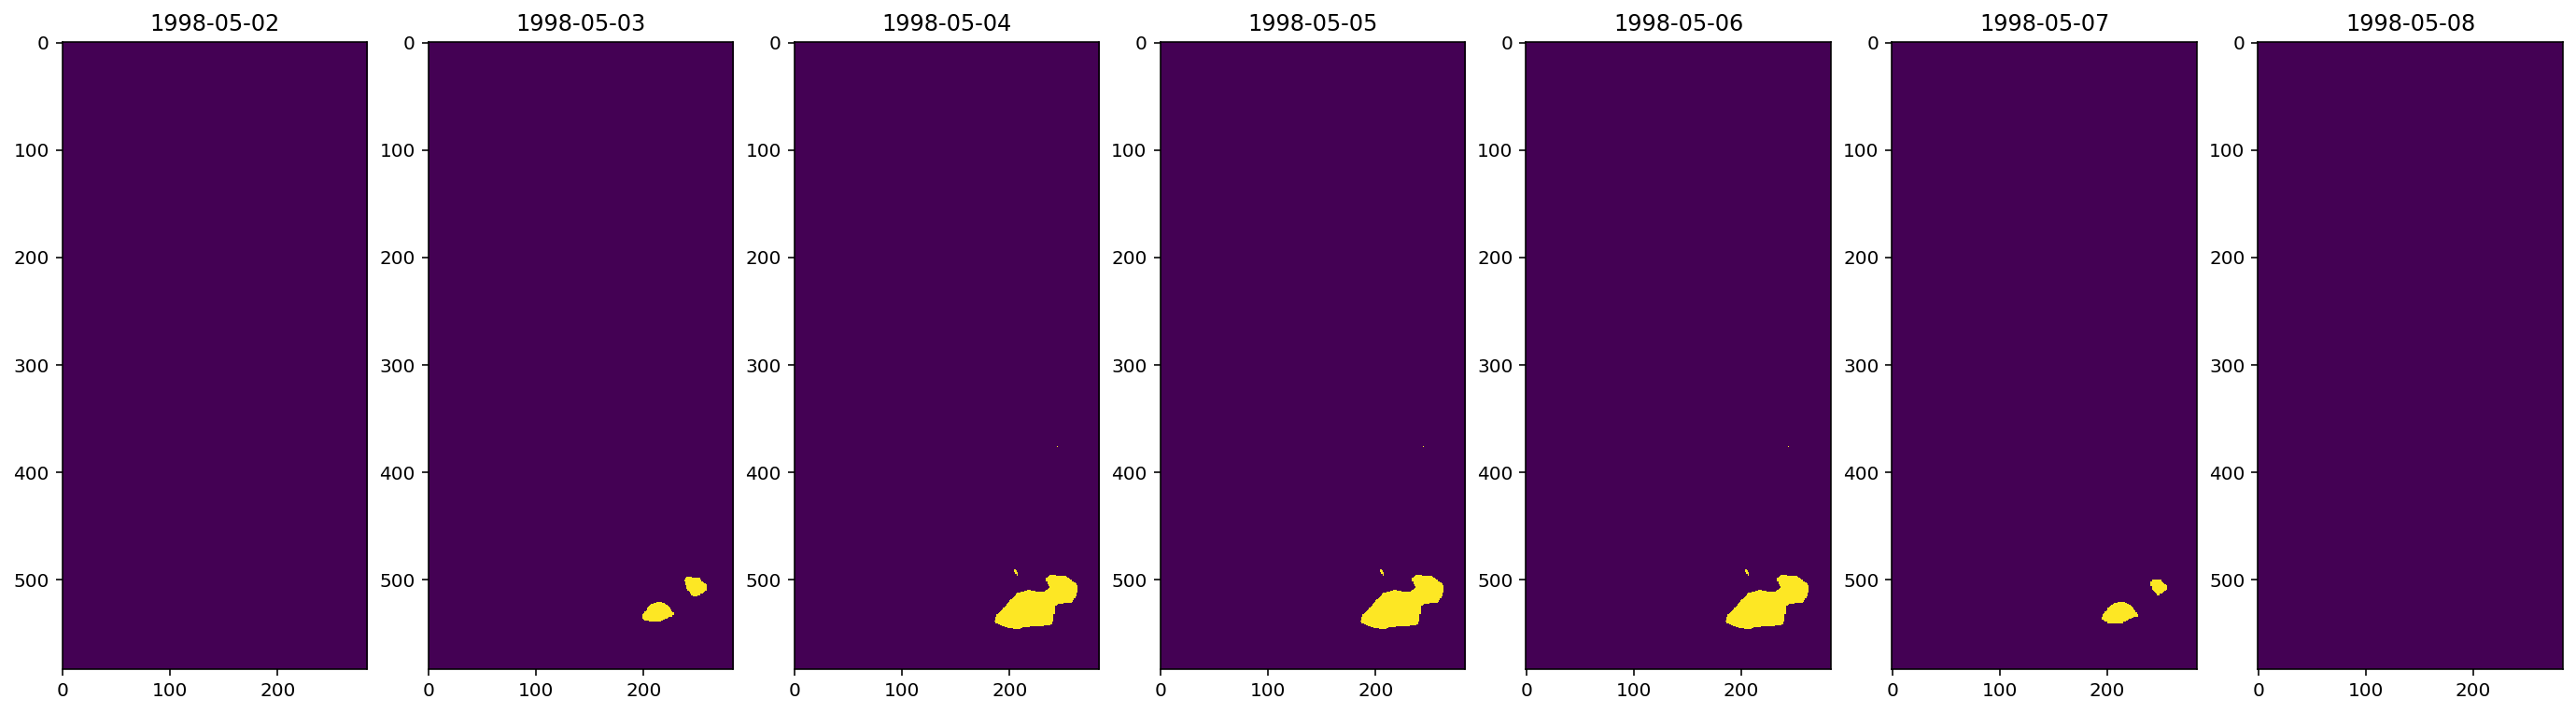

In [4]:
################################
# progress of an example heat event
################################

t_indexes = range(121,128)

dr = pd.date_range(start=f'1/1/{year}', periods=365, freq='D').date

fig, axs = plt.subplots(1, len(t_indexes), figsize=(24,12))

for i, idx in enumerate(t_indexes):
    H = arr3d[idx,:,:]
    ax = axs.ravel()[i]
    ax.imshow(H, interpolation='none')
    ax.set_title(dr[idx])


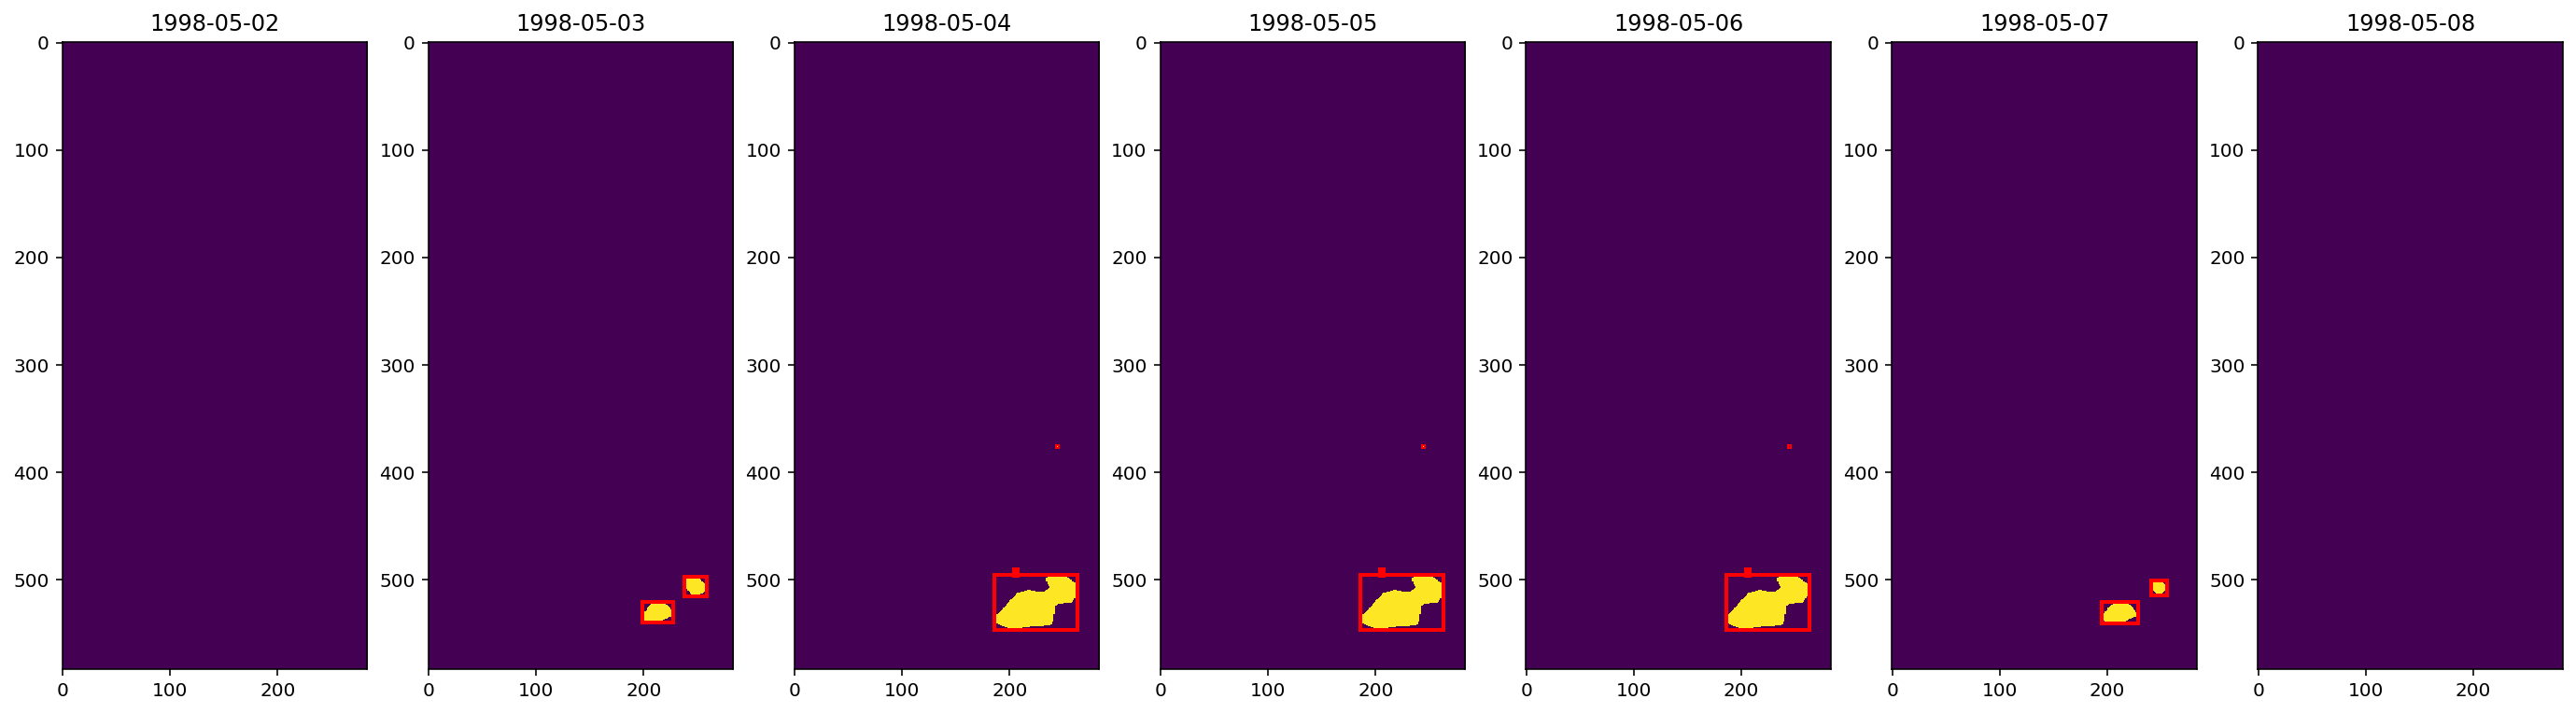

In [5]:
################################
# find boundary boxes 
################################

# uses parent-child hierarchy to merge small areas into fewer heat events
# runs for a single time slice (day)
# later, we will find a way to fuse these boundary bozes in time axis (3rd dimension)
# to find our objective: 'heat events' in 3d, 
# defined by ((x1,y1),(x2,y2),(t1,t2)) 3d slices
# OpenCV Contours Hierarchy documentation:
# https://vovkos.github.io/doxyrest-showcase/opencv/sphinxdoc/page_tutorial_py_contours_hierarchy.html#doxid-d9-d8b-tutorial-py-contours-hierarchy

# !pip install opencv-python-headless
import cv2
from matplotlib.patches import Rectangle
from typing import List, Tuple

def bounding_boxes(arr2d: np.array) -> List[tuple]:
    
    H = arr2d.astype(np.uint8)
    ret, thresh = cv2.threshold(H, 0, 1, 0, cv2.THRESH_BINARY)
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = [cv2.boundingRect(c) for c in contours]
    return boxes


fig, axs = plt.subplots(1, len(t_indexes), figsize=(24,12))

for i, idx in enumerate(t_indexes):
    
    arr2d = arr3d[idx,:,:]
    
    ax = axs.ravel()[i]
    ax.imshow(arr2d, interpolation='none')
    ax.set_title(dr[idx])
    
    boxes = bounding_boxes(arr2d)
    for b in boxes:
        x,y,w,h = b
        rect = Rectangle((x, y), w, h, color='red', fill=False, linewidth=2)
        ax.add_patch(rect)
    

In [7]:
################################
# pipeline to filter tiny windows and fuse overlapping ones 
################################

import itertools

def isoverlap(box1:tuple, box2:tuple) -> bool:
    """Return True if two windows overlap"""
    x1,y1,w1,h1 = box1
    x2,y2,w2,h2 = box2
    return not (x2>x1+w1 or x2+w2<x1 or y2>y1+h1 or y2+h2<y1)

assert(isoverlap((10,10,10,10), (9,9,10,10)) == True)
assert(isoverlap((10,10,10,10), (100,100,2,2)) == False)

def outer(box1:tuple, box2:tuple) -> tuple:
    """Fuse two windows into one, parent window."""
    x1,y1,w1,h1 = box1
    x2,y2,w2,h2 = box2
    x = min(x1,x2)
    y = min(y1,y2)
    w = max(x1+w1,x2+w2)-x
    h = max(y1+h1,y2+h2)-y
    return (x, y, w, h)

def istiny(box:tuple, min_area:int) -> bool:
    x,y,w,h = box
    return w*h <= min_area

def filter_tiny_ones(boxes:List[tuple]) -> List[tuple]:
    return [c for c in boxes if not istiny(c, 10)]

def collapse(boxes:List[tuple]) -> List[tuple]:
    
    for box1, box2 in itertools.combinations(boxes, 2):
        if isoverlap(box1,box2):
            boxes.remove(box1)
            boxes.remove(box2)
            boxes.append(outer(box1,box2))
            return collapse(boxes) # recursion

    boxes.sort(key=lambda _:_[0])
    return boxes

# test
boxes = [(186, 496, 77, 51), (204, 491, 4, 6), (244, 376, 1, 1), (10,12,3,4), (9,9,10,10)]
boxes = filter_tiny_ones(boxes)
boxes = collapse(boxes)
boxes

[(9, 9, 10, 10), (186, 491, 77, 56)]

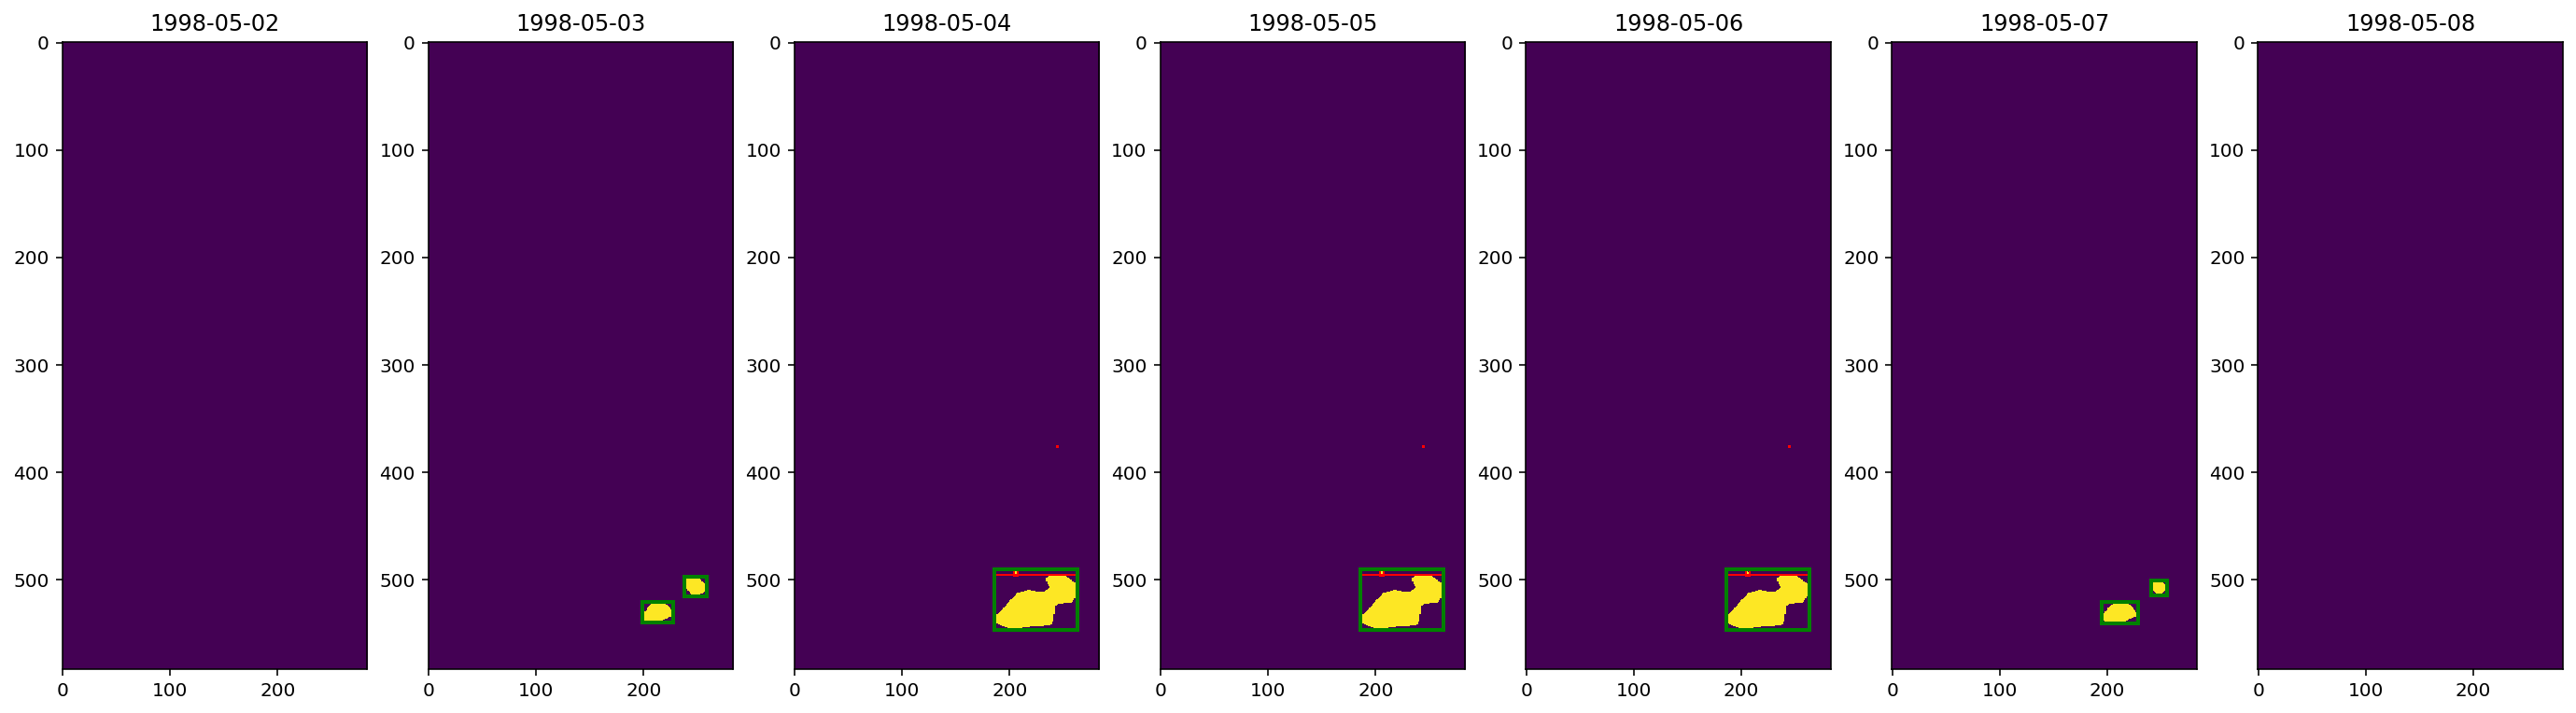

In [8]:
################################
# apply the functions above to the row-windows openCV found:
################################

fig, axs = plt.subplots(1, len(t_indexes), figsize=(24,12))

for i, idx in enumerate(t_indexes):
    
    arr2d = arr3d[idx,:,:]
    
    ax = axs.ravel()[i]
    ax.imshow(arr2d, interpolation='none')
    ax.set_title(dr[idx])
    
    boxes = bounding_boxes(arr2d)
    for b in boxes:
        x,y,w,h = b
        rect = Rectangle((x, y), w, h, color='red', fill=False, linewidth=1)
        ax.add_patch(rect)
    boxes2 = collapse(filter_tiny_ones(boxes))

    for c in boxes2:
        x,y,w,h = c
        rect = Rectangle((x, y), w, h, color='green', fill=False, linewidth=2)
        ax.add_patch(rect)


In [88]:
################################
# Next: merge these 2d-merged windows, this time in'time' axis, i.e in 3D
################################

"""Walk on time axis and collapse boxes of consequtive days that 
hold boxes, i.e. heat event(s). The output is metadata only, with
the start and end time of each heat event detected, and the largest
box that frames the geolocation of its extend. 

I.e., the func `collapse` acts on detected windows, 
this time along the 3rd, 'time' axis.

For example, an event is detected from 1998-01-01 to 1998-01-05, started in
LA and moved along to San Diago during that 5 days. The rectangle will be 
large enough to encapsulate both cities.

pseudo-code be like:
ds.groupBy(heat-event, axis='time').agg(min-date, max-date, encapsulating-box(x,y,w,h)).. 

In the output, t1 and t2 are inclusive, like [t1,t2]
"""
    
def array2boxes(arr2d:np.array) -> List[tuple]:
    """Pipeline. Takes a time-slice (2D array) and returns the boxes."""
    boxes = bounding_boxes(arr2d)
    boxes = filter_tiny_ones(boxes)
    boxes = collapse(boxes)
    return boxes

# (Later I replaced the below for loop with equal pandas ops, as follows.)

def groupby_heat_events(arr3d:np.array) -> List[dict]:

    bucket = [] 
    events = []

    num_days = arr3d.shape[0]
    
    for i in range(num_days):

        arr2d = arr3d[i,:,:]
        boxes = array2boxes(arr2d)

        if not boxes and not bucket:
            # no boxes that day
            pass
        elif boxes and not bucket:
            # 1st day of an event
            t1 = i
            bucket += boxes
        elif boxes and bucket:
            # 2nd, 3rd,.. day of an event
            bucket += boxes
            
            if i == num_days-1:
                # if the last day of the data was still a heat event
                t2 = i
                events += [dict(t1=t1, t2=t2, boxes=bucket)]
                bucket = []
                
        elif not boxes and bucket:
            # last day of an event
            t2 = i-1
            events += [dict(t1=t1, t2=t2, boxes=bucket)]
            bucket = []
        else:
            raise KeyError("!?")

    for e in events:
        e['boxes'] = collapse(e['boxes'])

    return pd.DataFrame(events)   

groupby_heat_events(arr3d)

,t1,t2,boxes
0,128,139,"[(82, 18, 21, 30), (141, 185, 7, 8), (144, 176..."
1,147,149,"[(0, 3, 24, 13), (225, 333, 9, 8), (229, 362, ..."
2,154,158,"[(73, 33, 7, 7), (145, 177, 3, 5), (203, 524, ..."
3,163,167,"[(140, 190, 5, 3), (145, 176, 3, 6), (235, 371..."
4,171,177,"[(156, 536, 11, 34), (178, 498, 106, 86), (218..."
5,180,186,"[(0, 3, 26, 13), (56, 19, 29, 43), (182, 499, ..."
6,190,192,"[(248, 560, 36, 24)]"
7,196,200,"[(190, 516, 41, 32), (203, 490, 5, 6), (236, 4..."
8,212,221,"[(139, 185, 9, 9), (140, 169, 10, 15), (166, 1..."
9,226,230,"[(195, 516, 35, 26), (201, 487, 9, 12), (237, ..."


In [89]:
# This func does the same, just shorter.

def groupby_heat_events(arr3d:np.array) -> List[dict]:
    rows = []
    num_days = arr3d.shape[0]

    for i in range(num_days):
        arr2d = arr3d[i,:,:]
        boxes = array2boxes(arr2d)
        rows += [dict(time=i, boxes=boxes)]
    df = pd.DataFrame(rows)
    df['hasEvent'] = df['boxes'].apply(lambda x: len(x)) > 0
    df['label'] = df['hasEvent'].diff().ne(False).cumsum()

    dff = df[df['hasEvent']]

    dfg = dff.groupby('label').agg({
        'time':[np.min,np.max], 
        'boxes':lambda _: collapse(np.sum(_))
    }).reset_index()
    dfg.columns = ['label', 'i1', 'i2', 'boxes']
    dfg = dfg.assign(d1=dr[dfg['i1']], d2=dr[dfg['i2']])
    dfg = dfg.drop('label', axis=1)
    
    return dfg


In [94]:
# Lets test on another year!

year = 1993
dr = pd.date_range(start=f'1/1/{year}', periods=365, freq='D').date
arr3d = np.load(f'./arr_heat3d/arr_heat3d-{year}.npy')

df_events = groupby_heat_events(arr3d)
df_events

,i1,i2,boxes,d1,d2
0,121,126,"[(200, 524, 21, 15), (239, 373, 11, 7)]",1993-05-02,1993-05-07
1,128,133,"[(0, 0, 30, 16), (51, 15, 33, 47), (226, 294, ...",1993-05-09,1993-05-14
2,139,158,"[(76, 35, 4, 5), (145, 178, 3, 4), (162, 176, ...",1993-05-20,1993-06-08
3,168,174,"[(209, 526, 14, 9), (227, 335, 6, 5), (233, 36...",1993-06-18,1993-06-24
4,193,197,"[(198, 264, 41, 42), (241, 365, 23, 24)]",1993-07-13,1993-07-17
5,212,215,"[(75, 35, 5, 5), (169, 486, 91, 71), (232, 368...",1993-08-01,1993-08-04
6,217,219,"[(71, 21, 10, 19)]",1993-08-06,1993-08-08
7,225,235,"[(0, 3, 10, 13), (141, 190, 4, 3), (142, 173, ...",1993-08-14,1993-08-24
8,238,241,"[(192, 493, 78, 68)]",1993-08-27,1993-08-30
9,247,251,"[(60, 19, 25, 29), (134, 192, 9, 12), (177, 48...",1993-09-05,1993-09-09


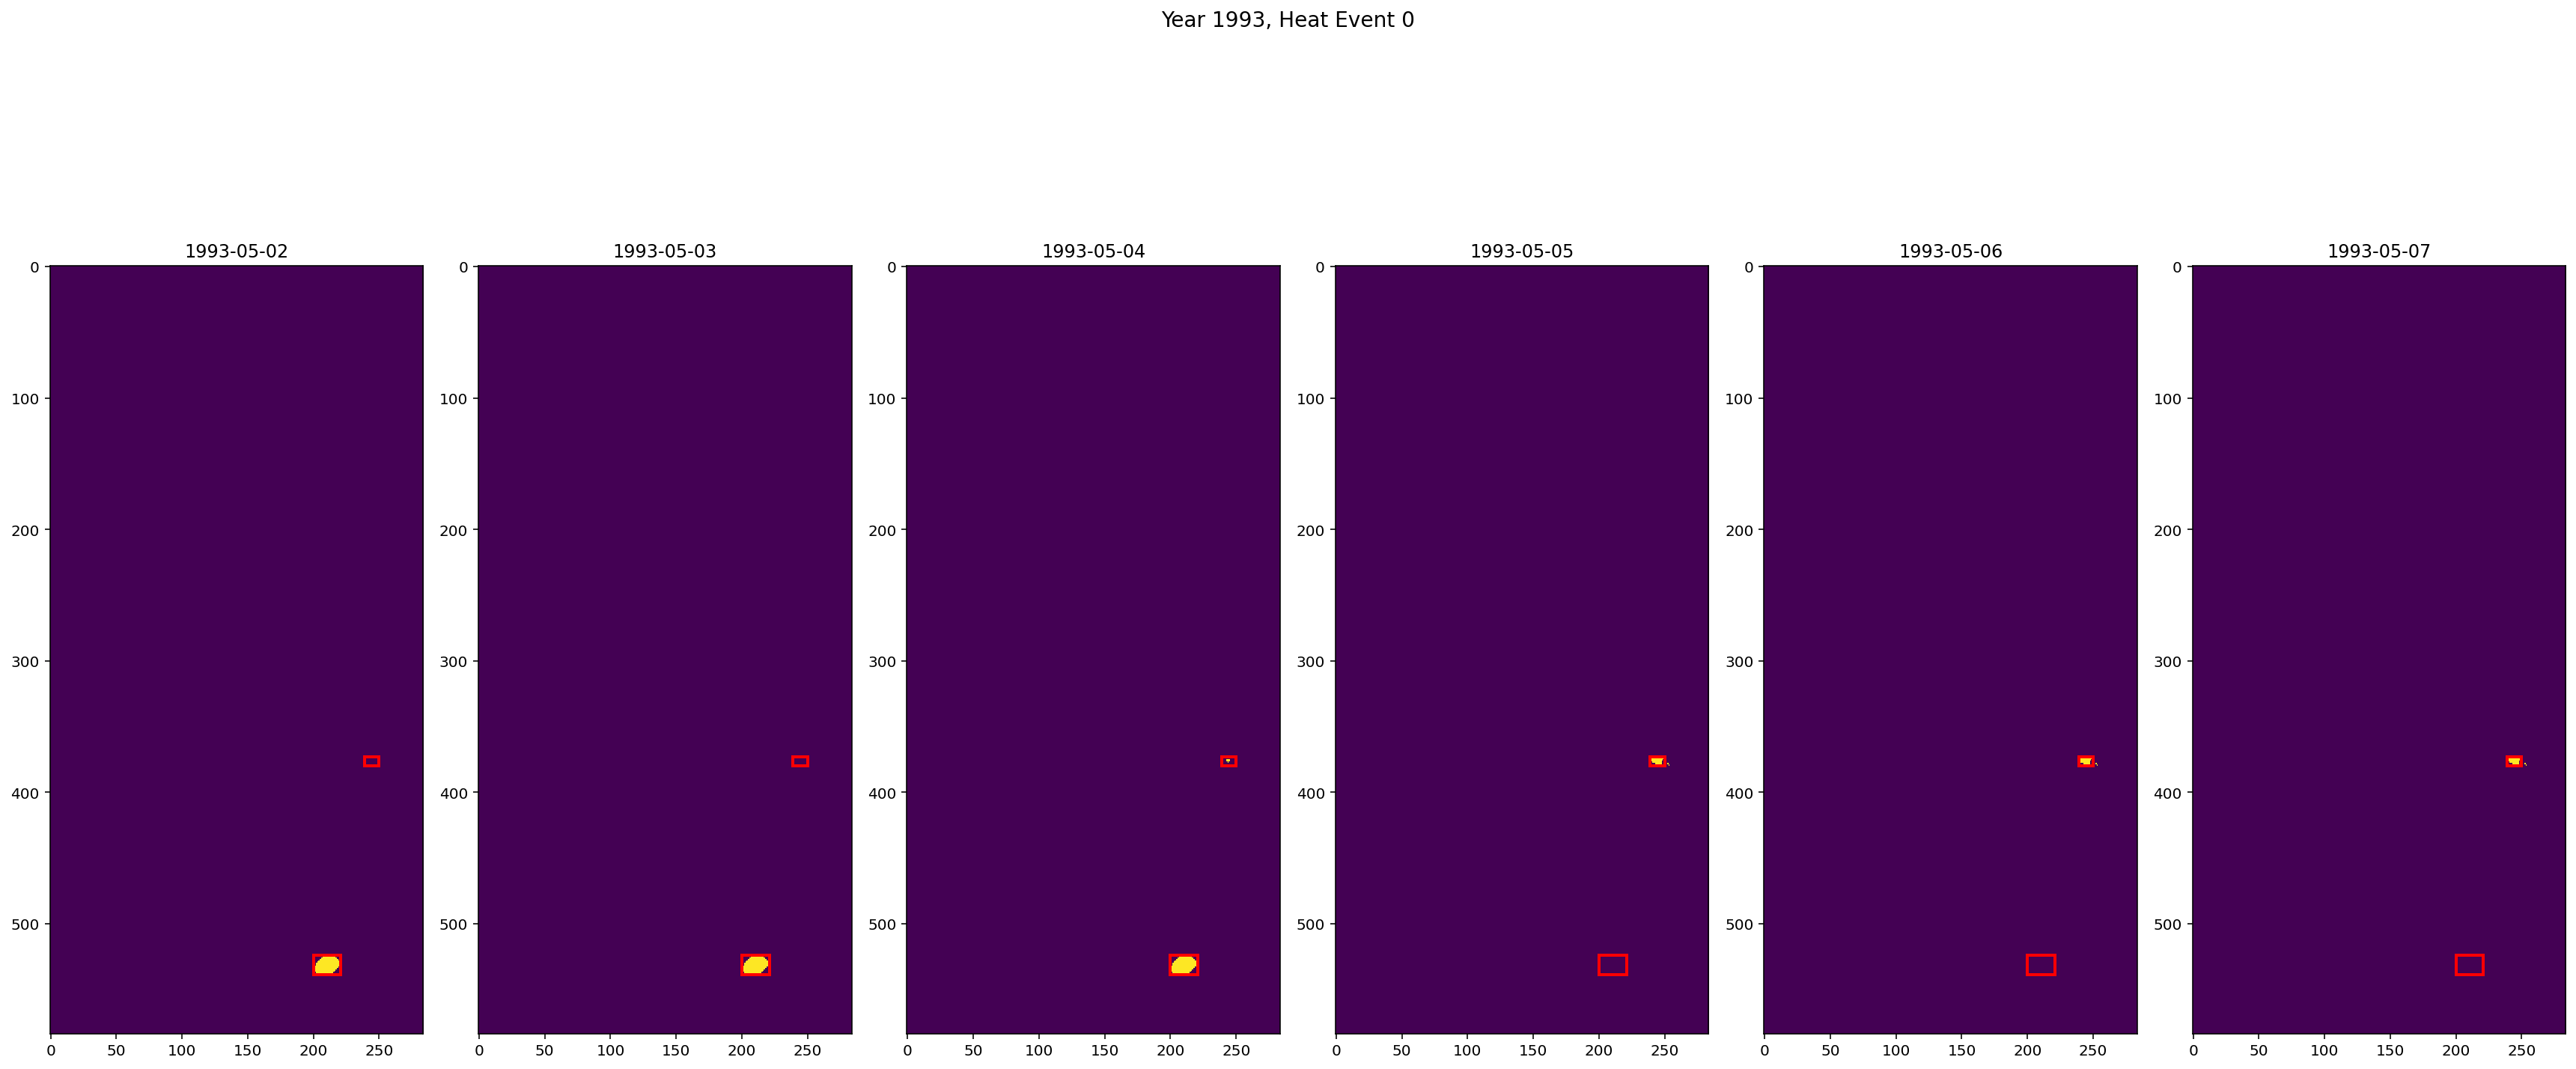

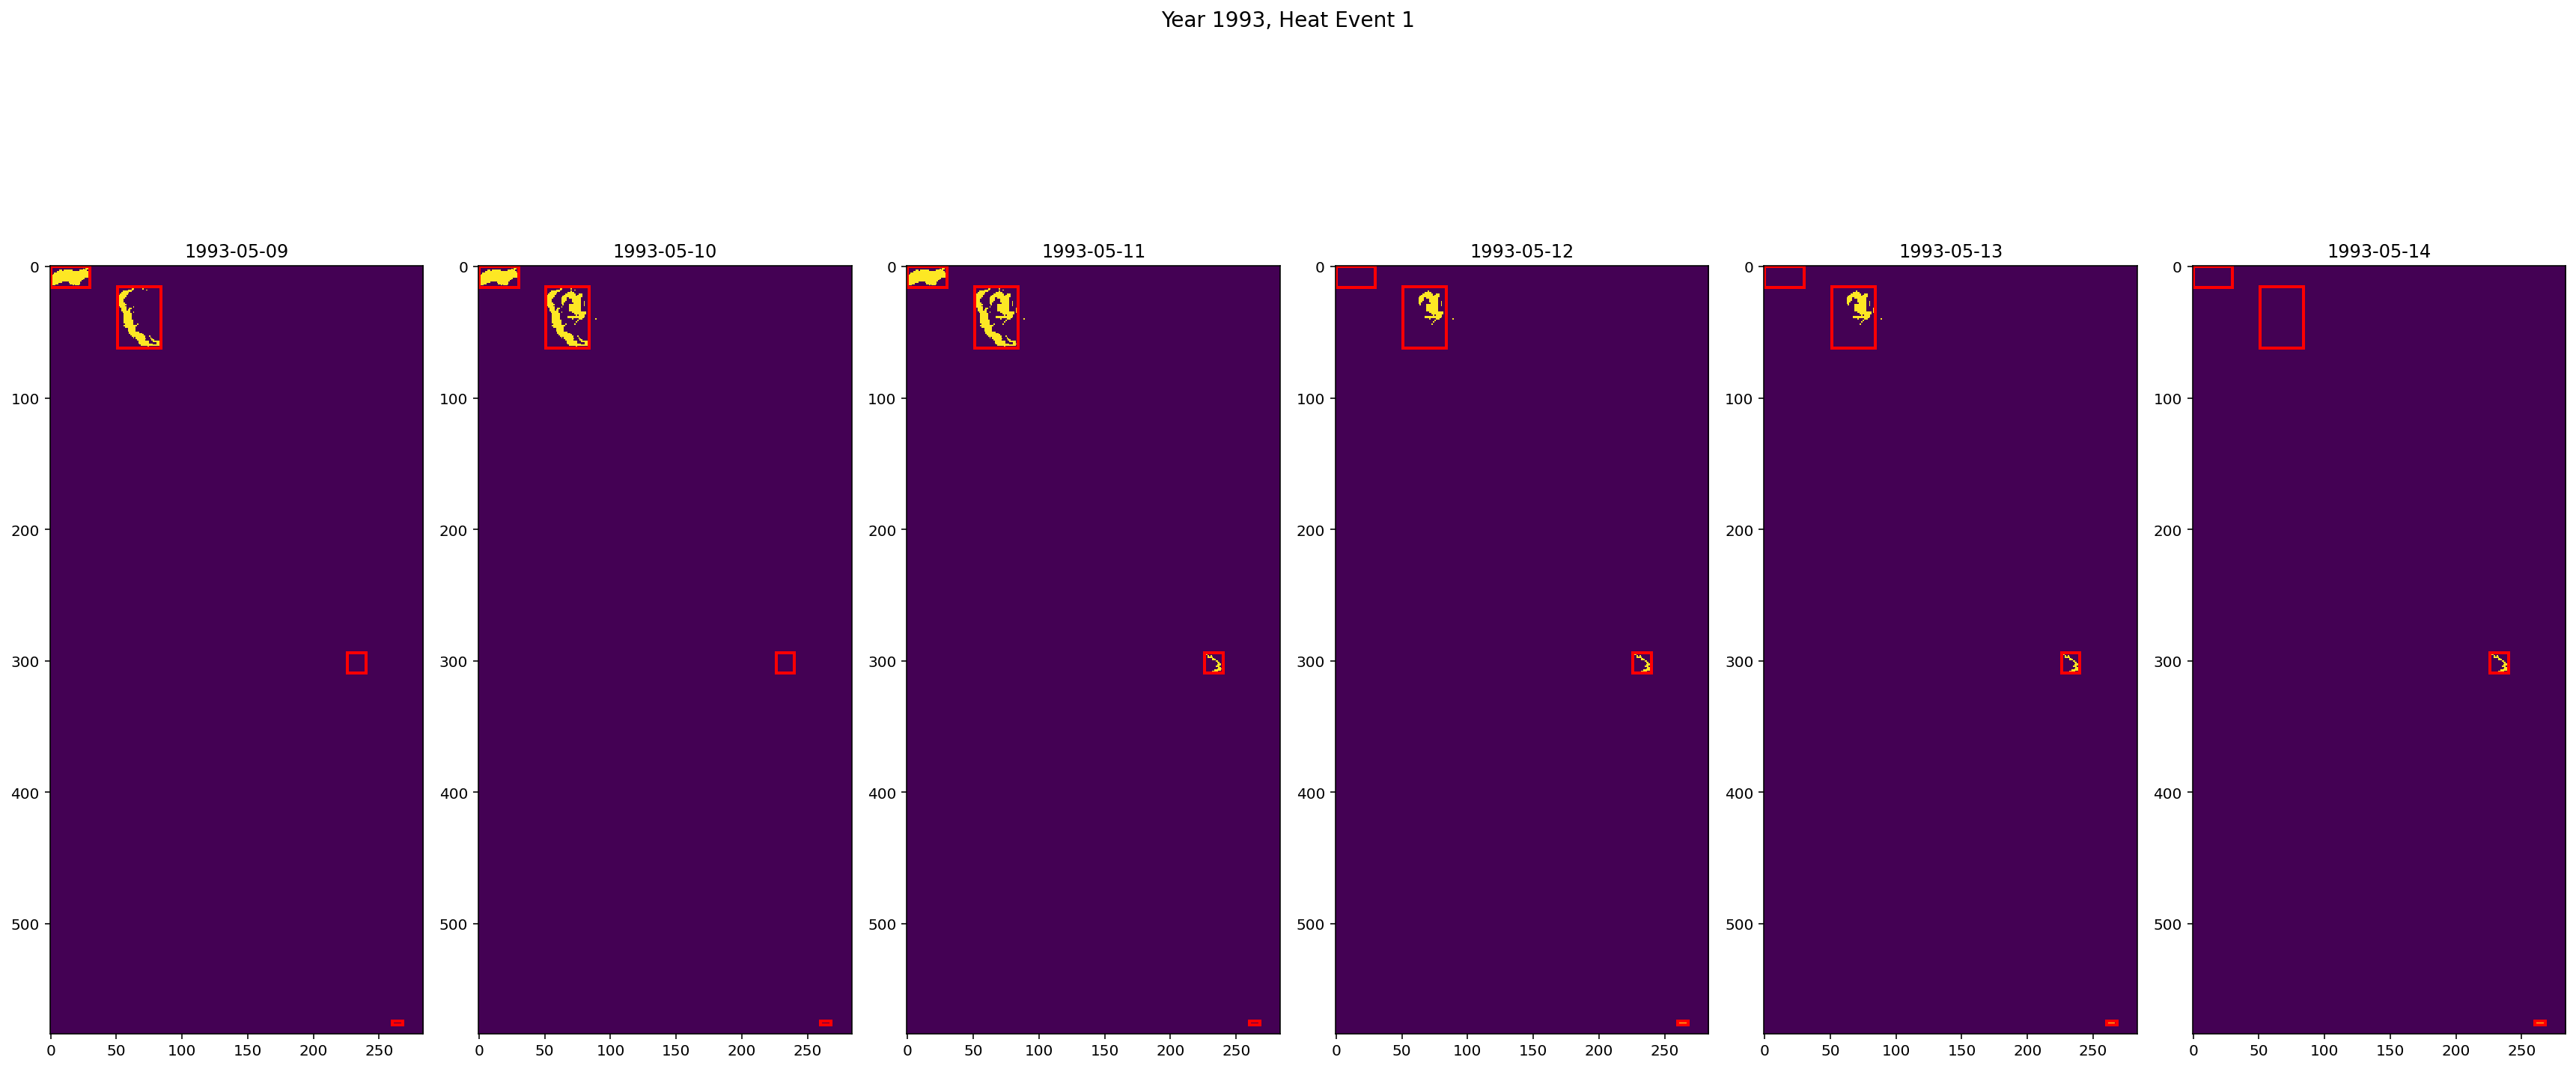

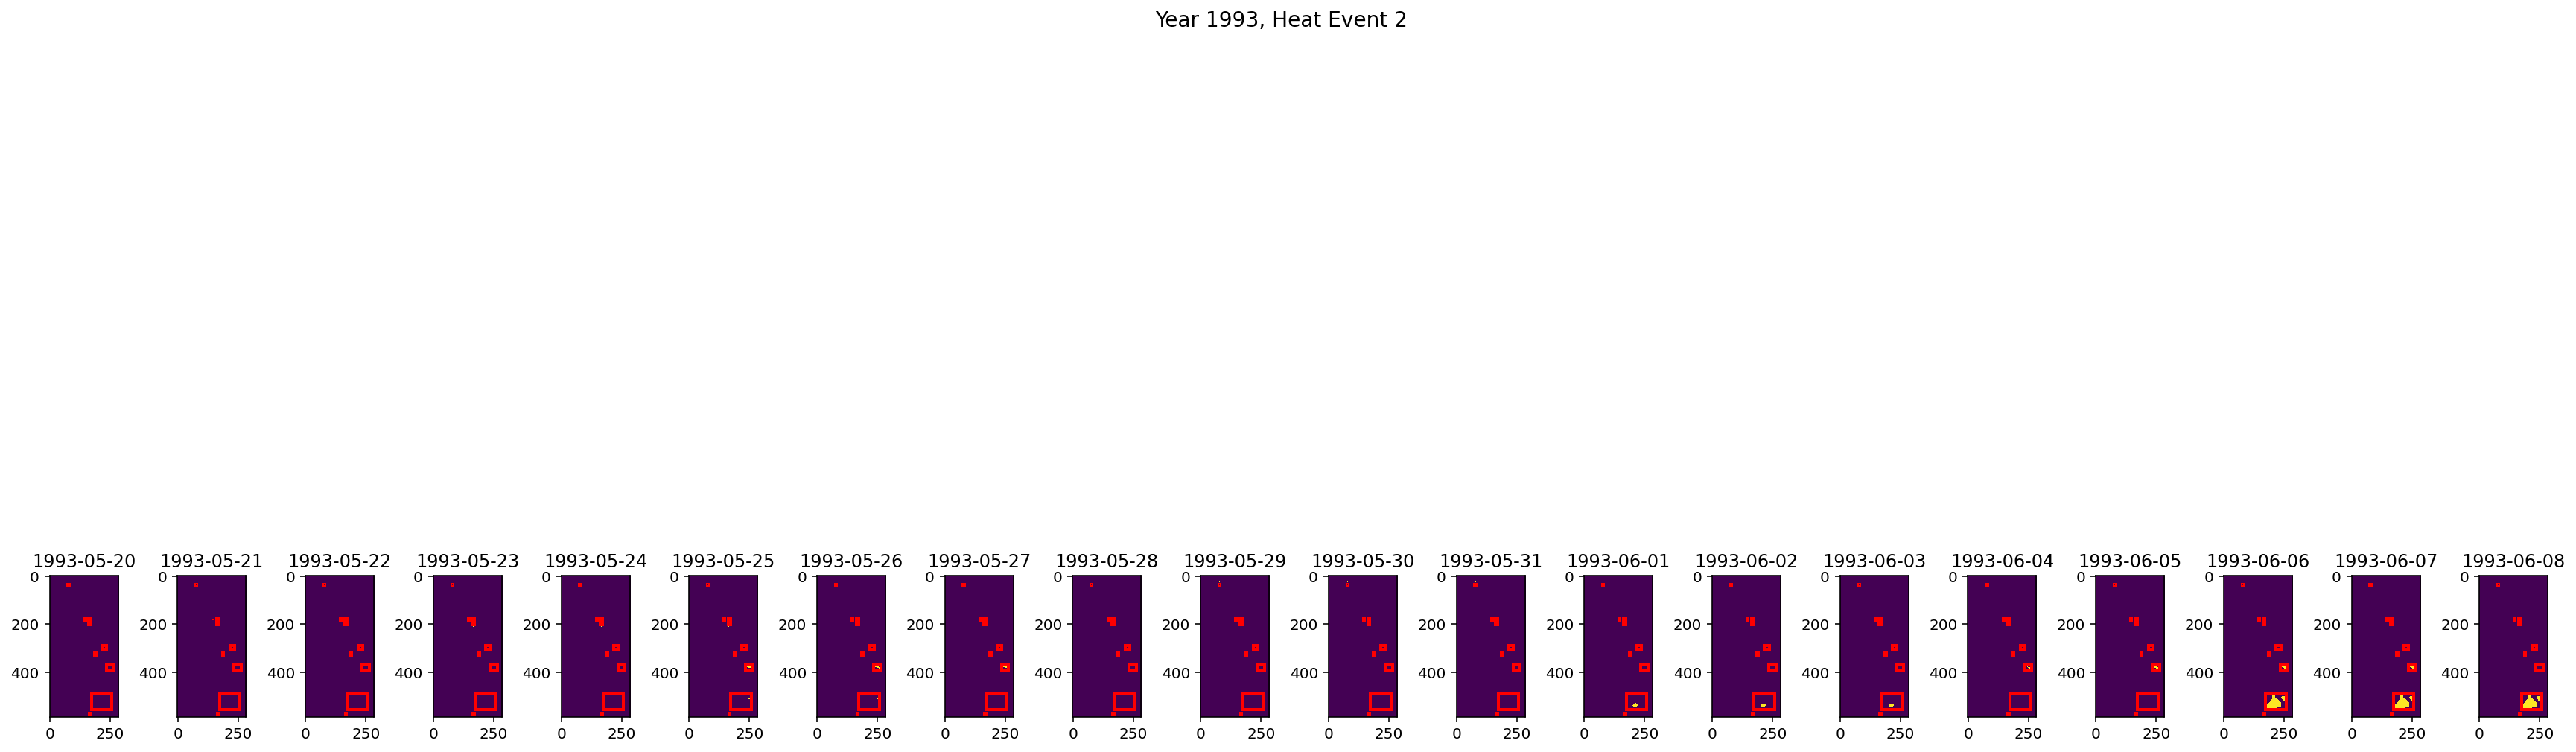

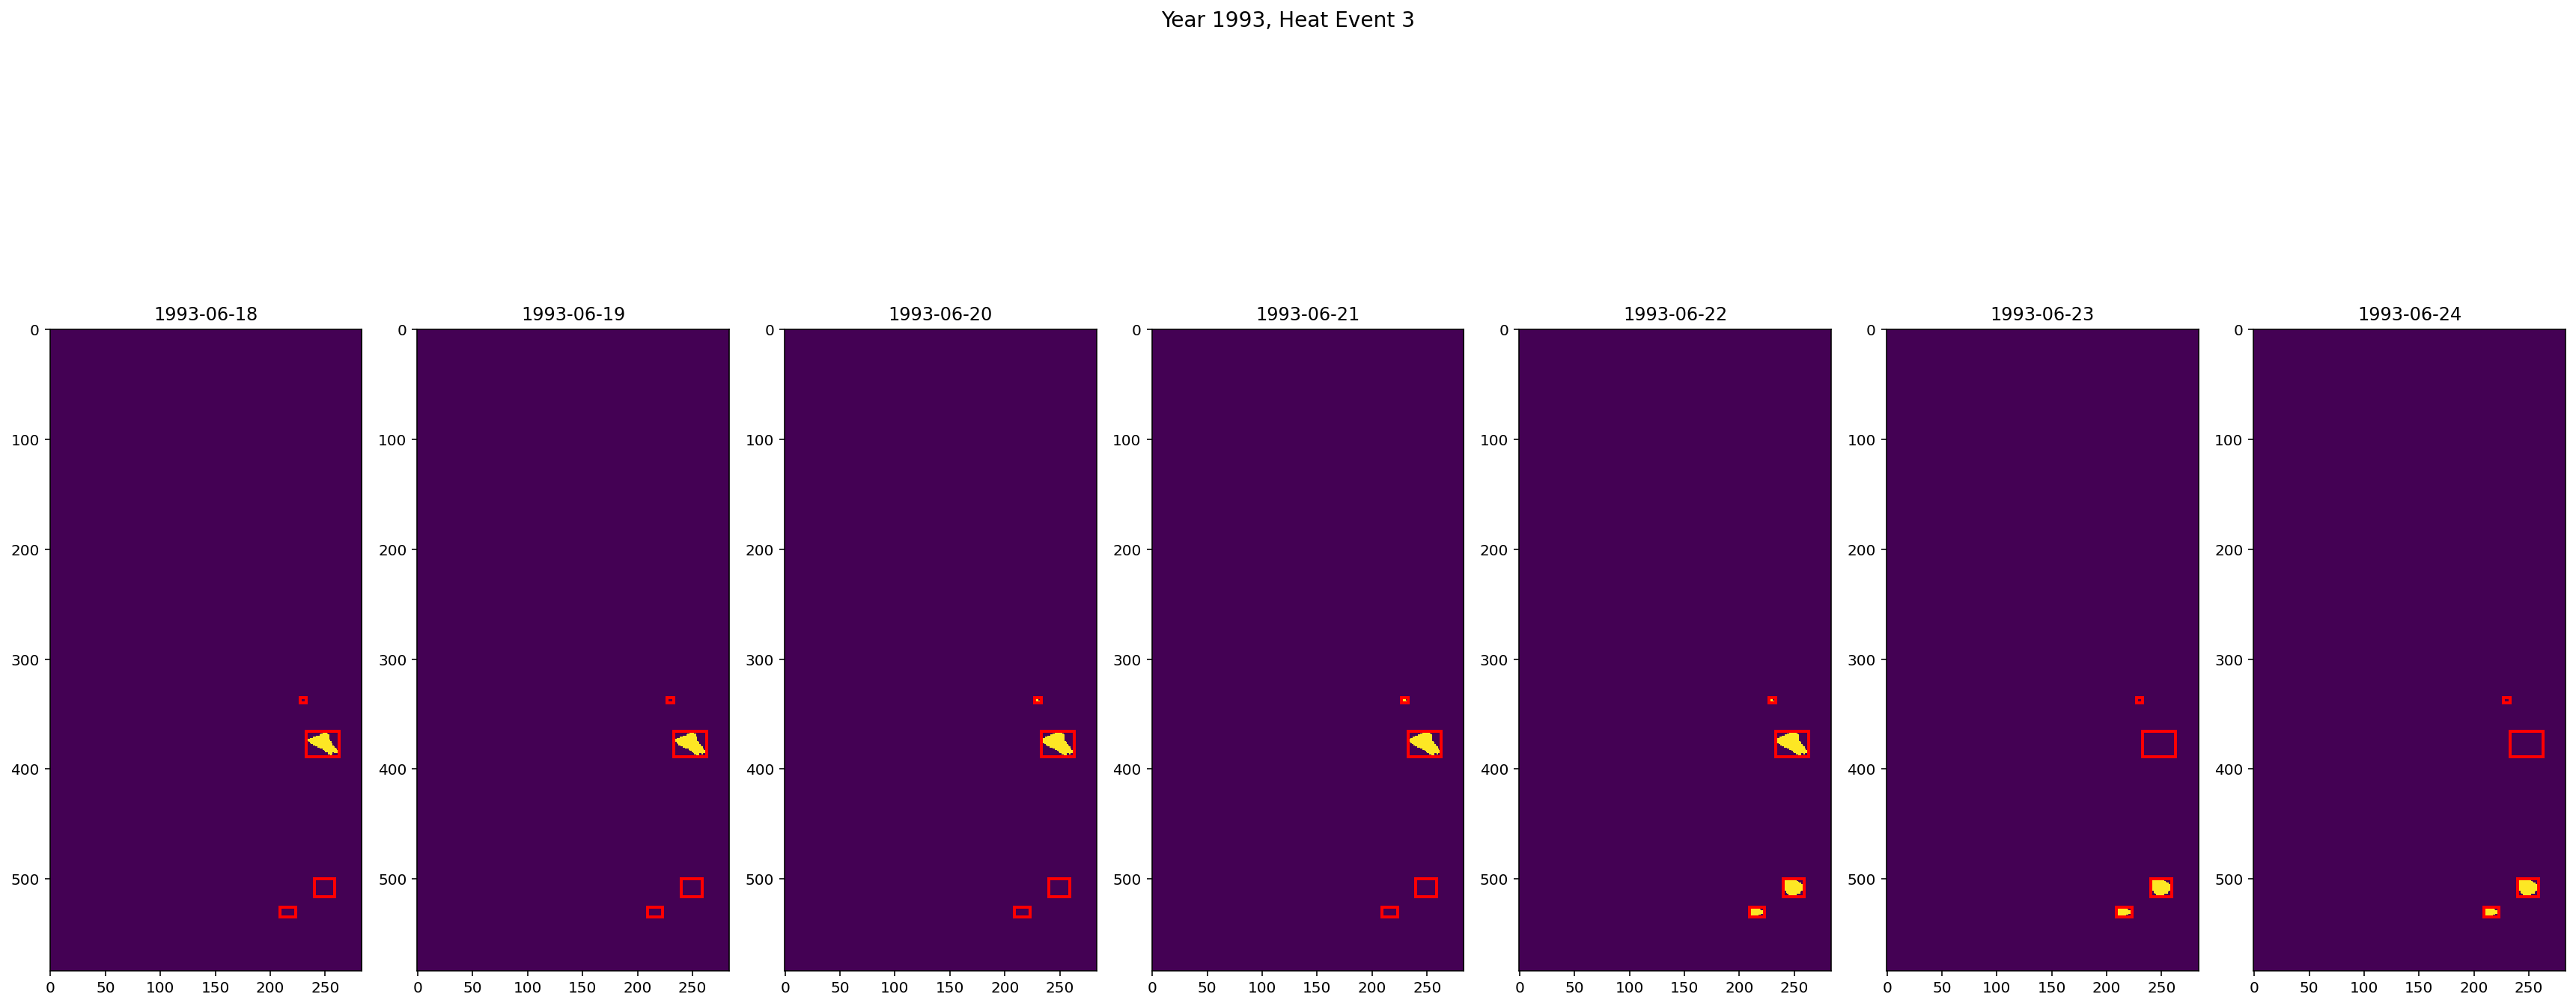

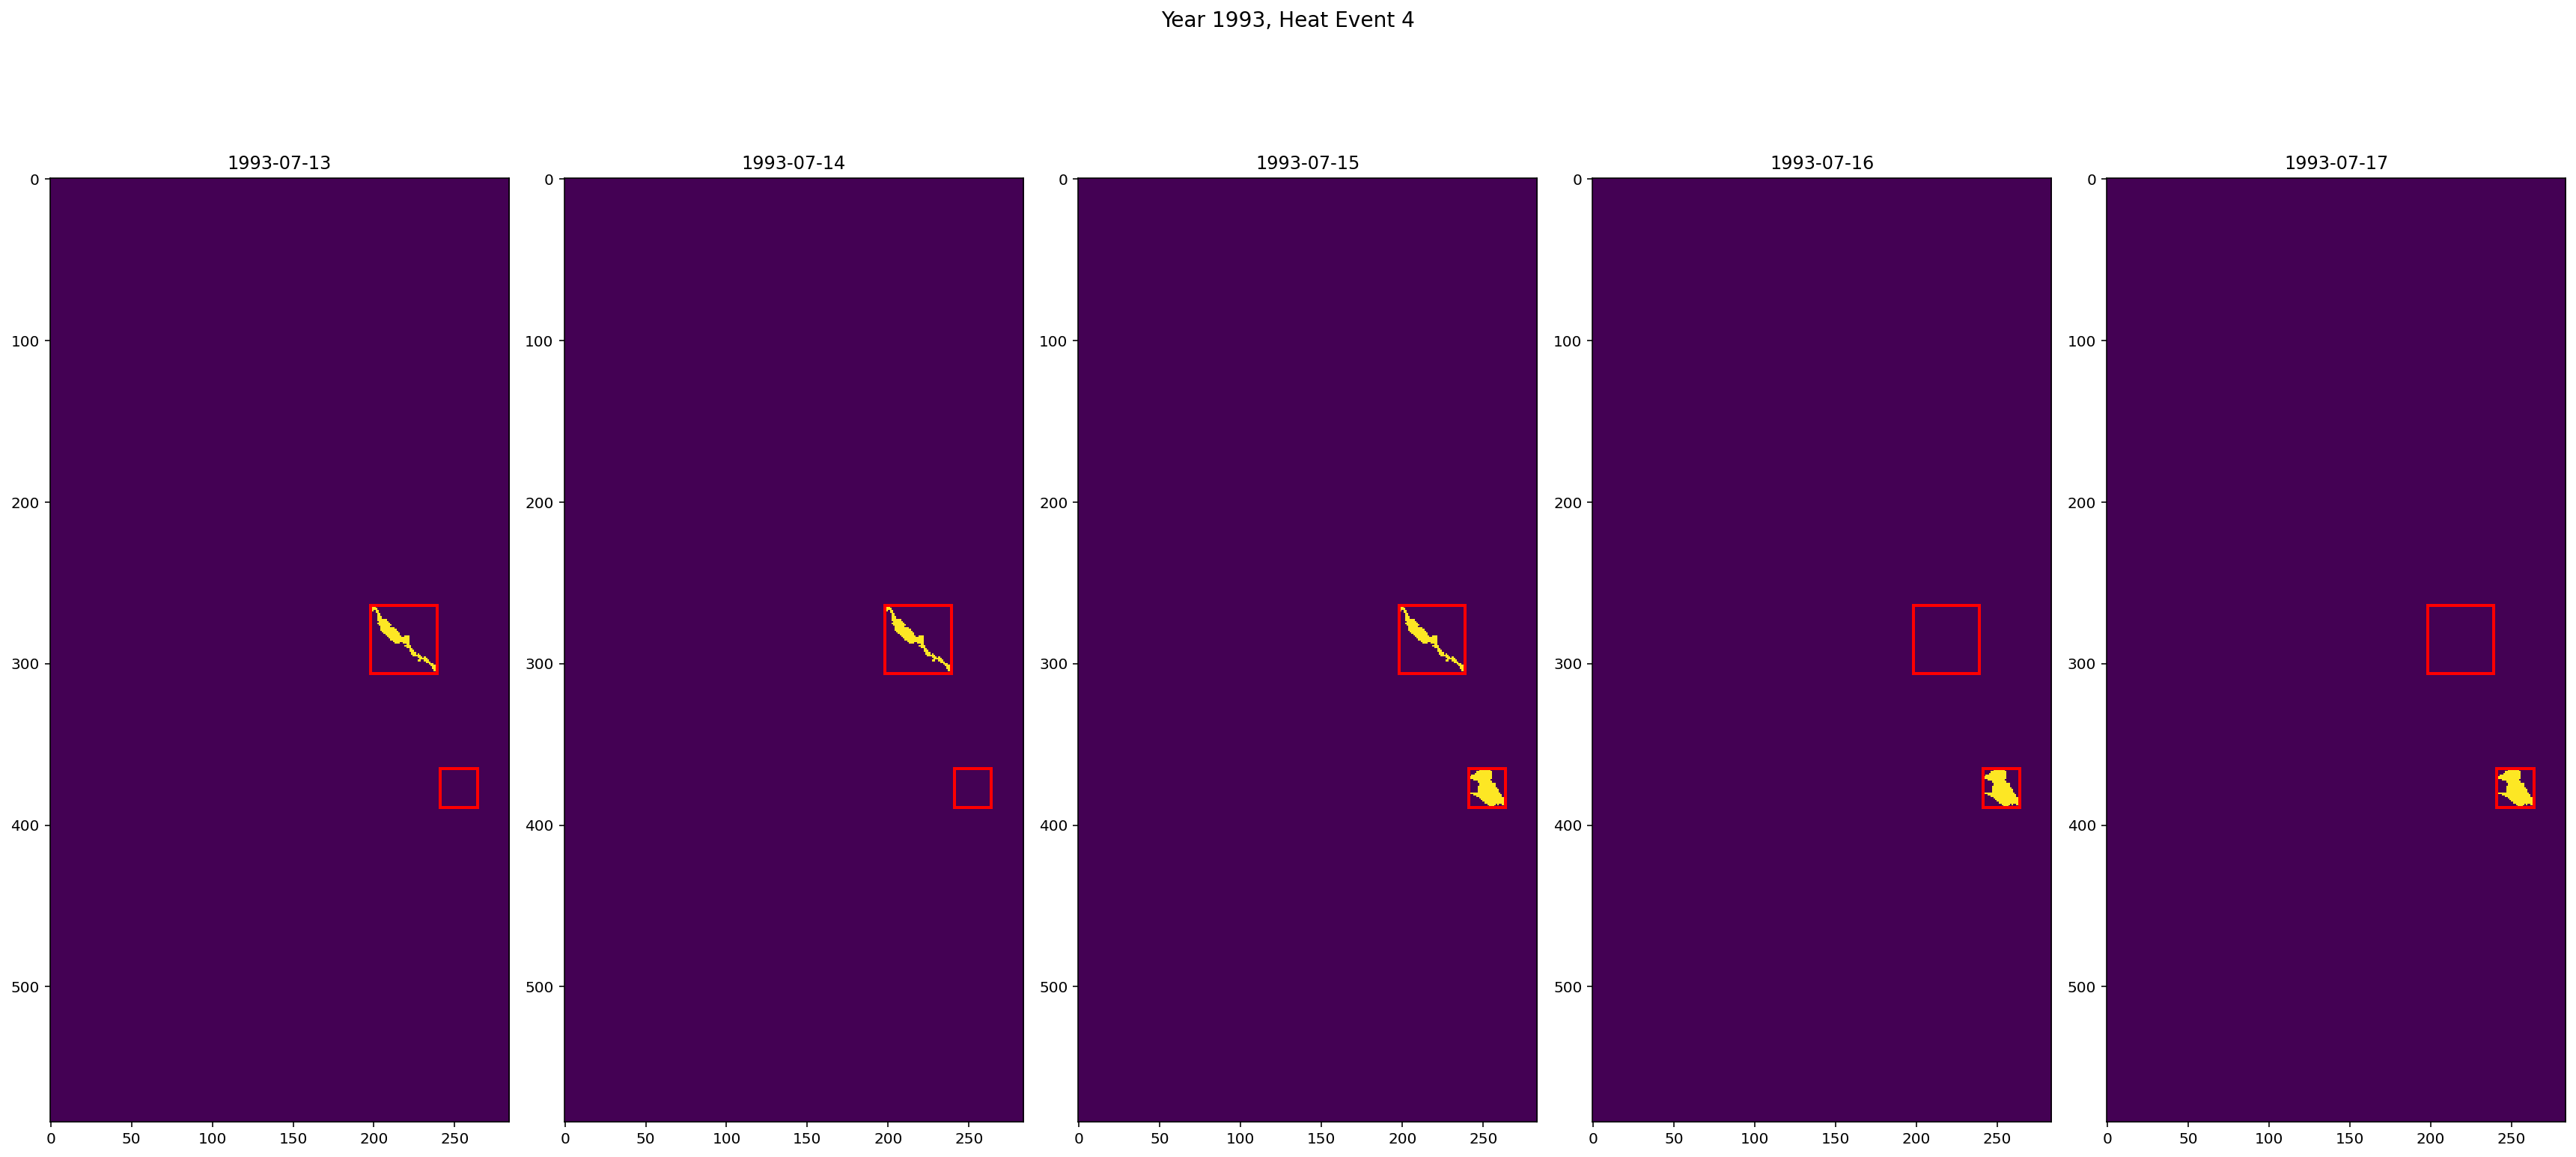

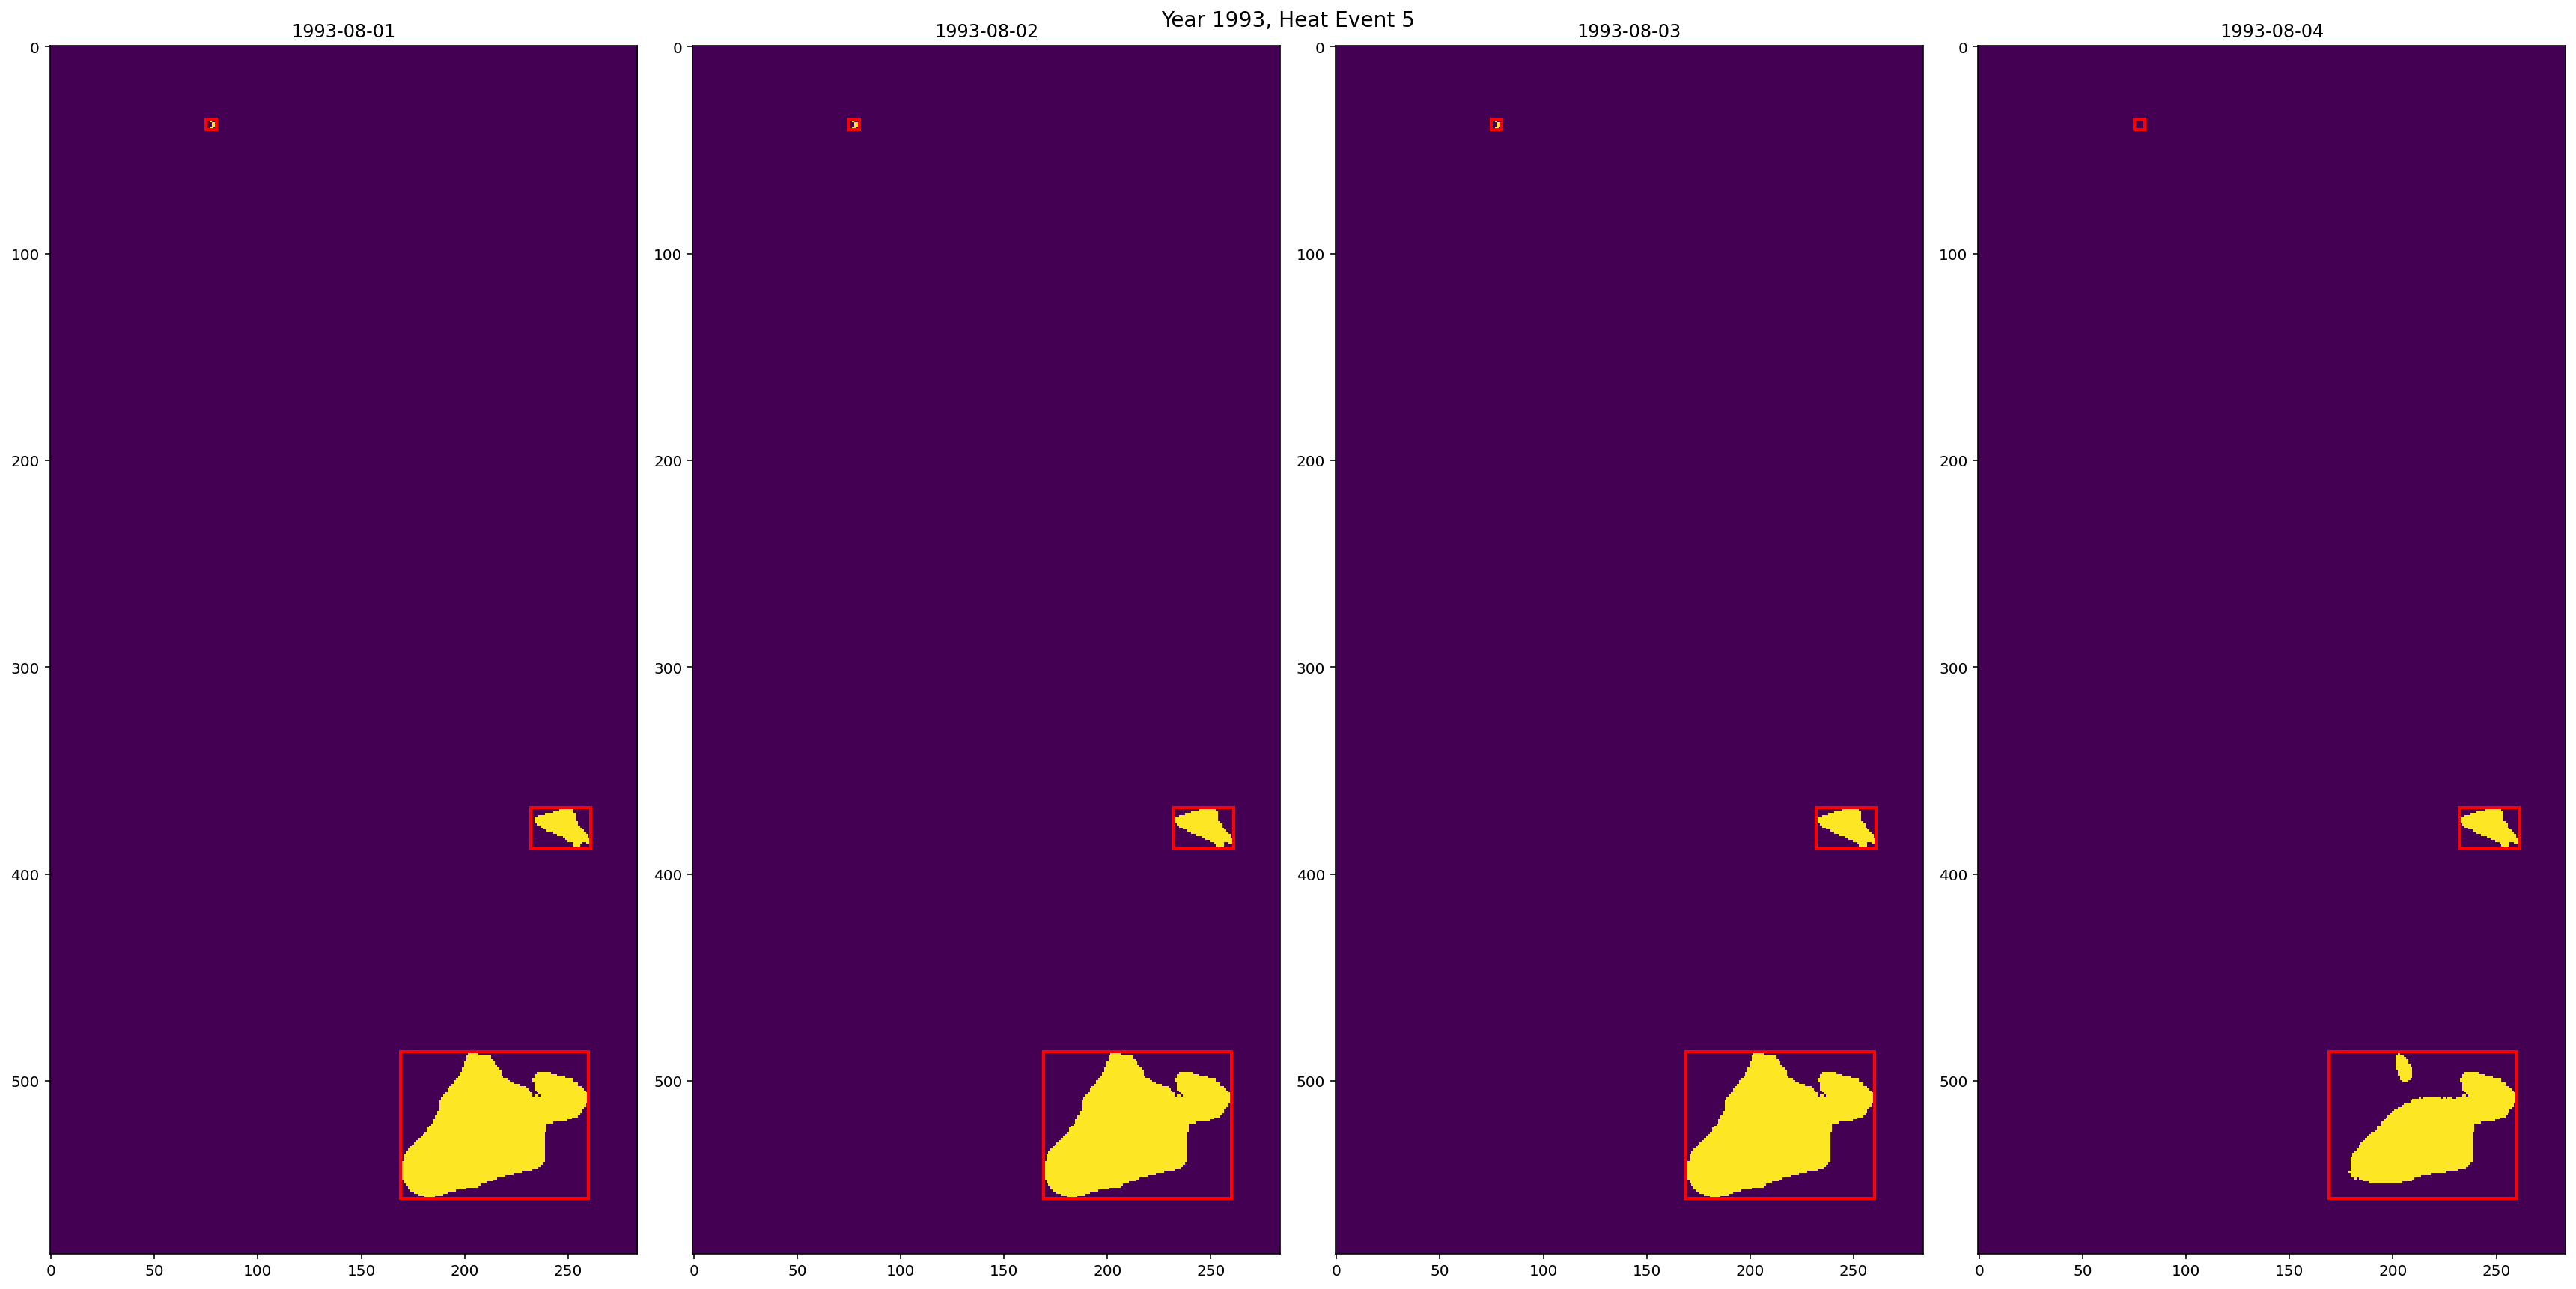

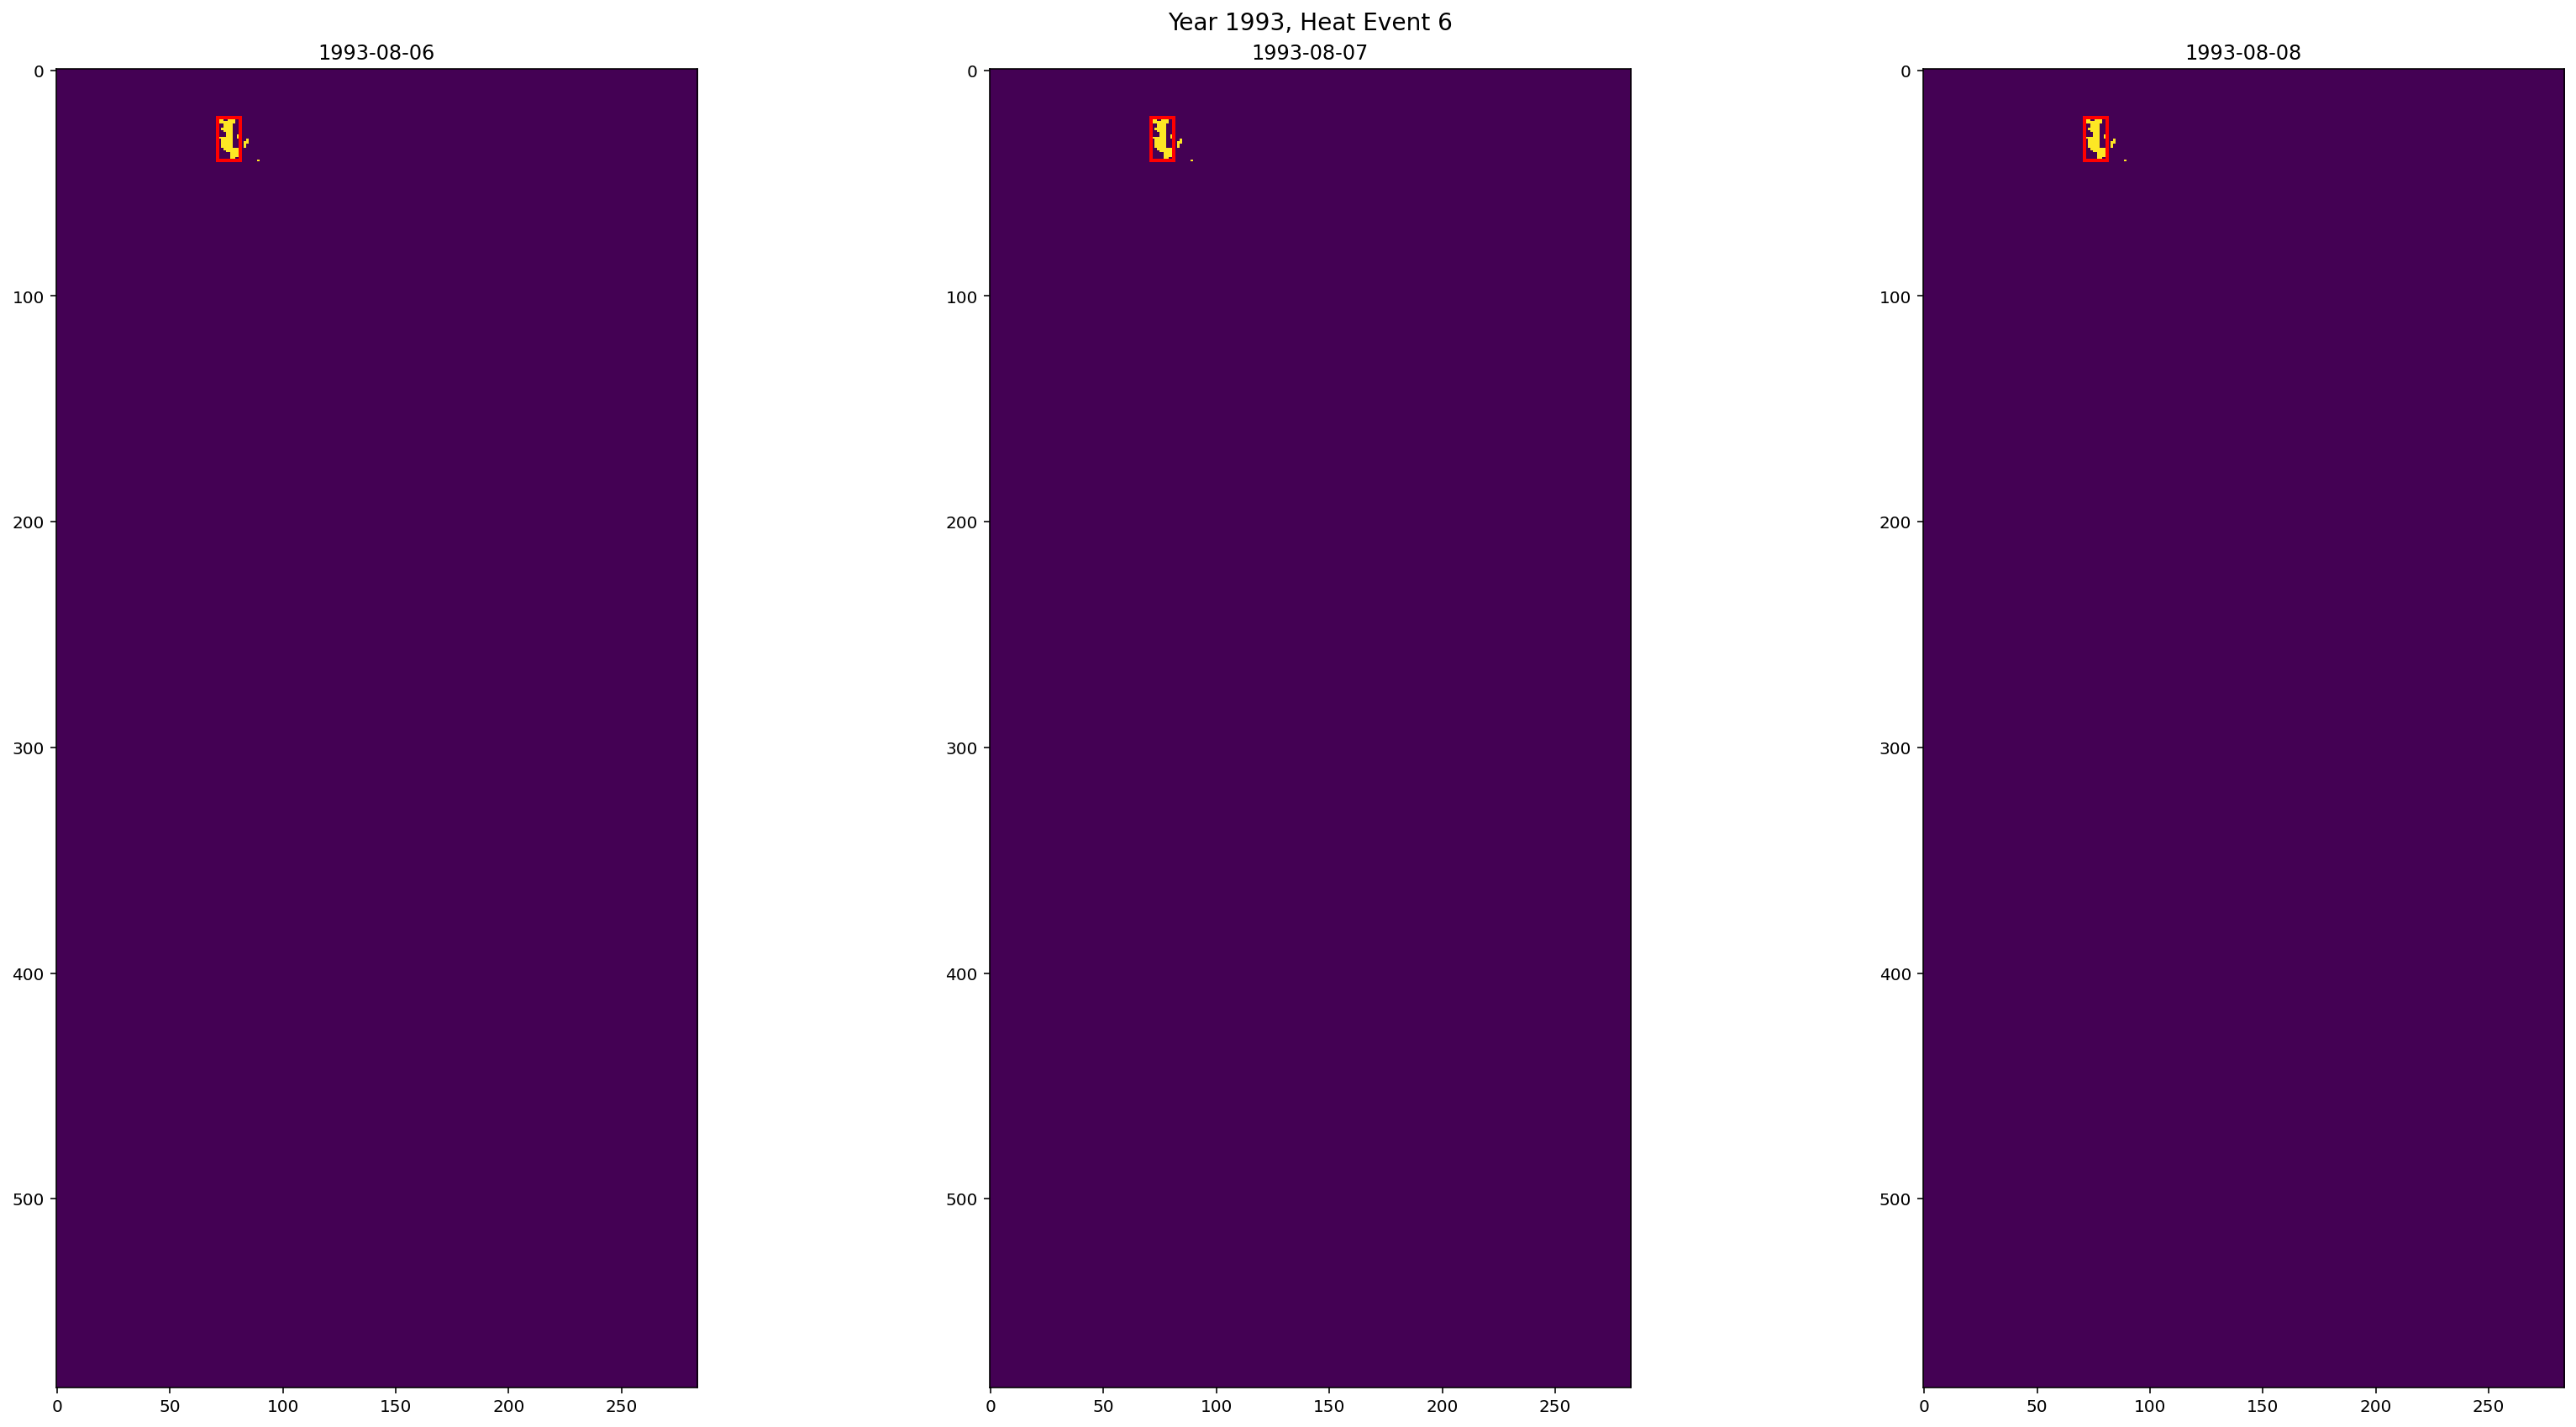

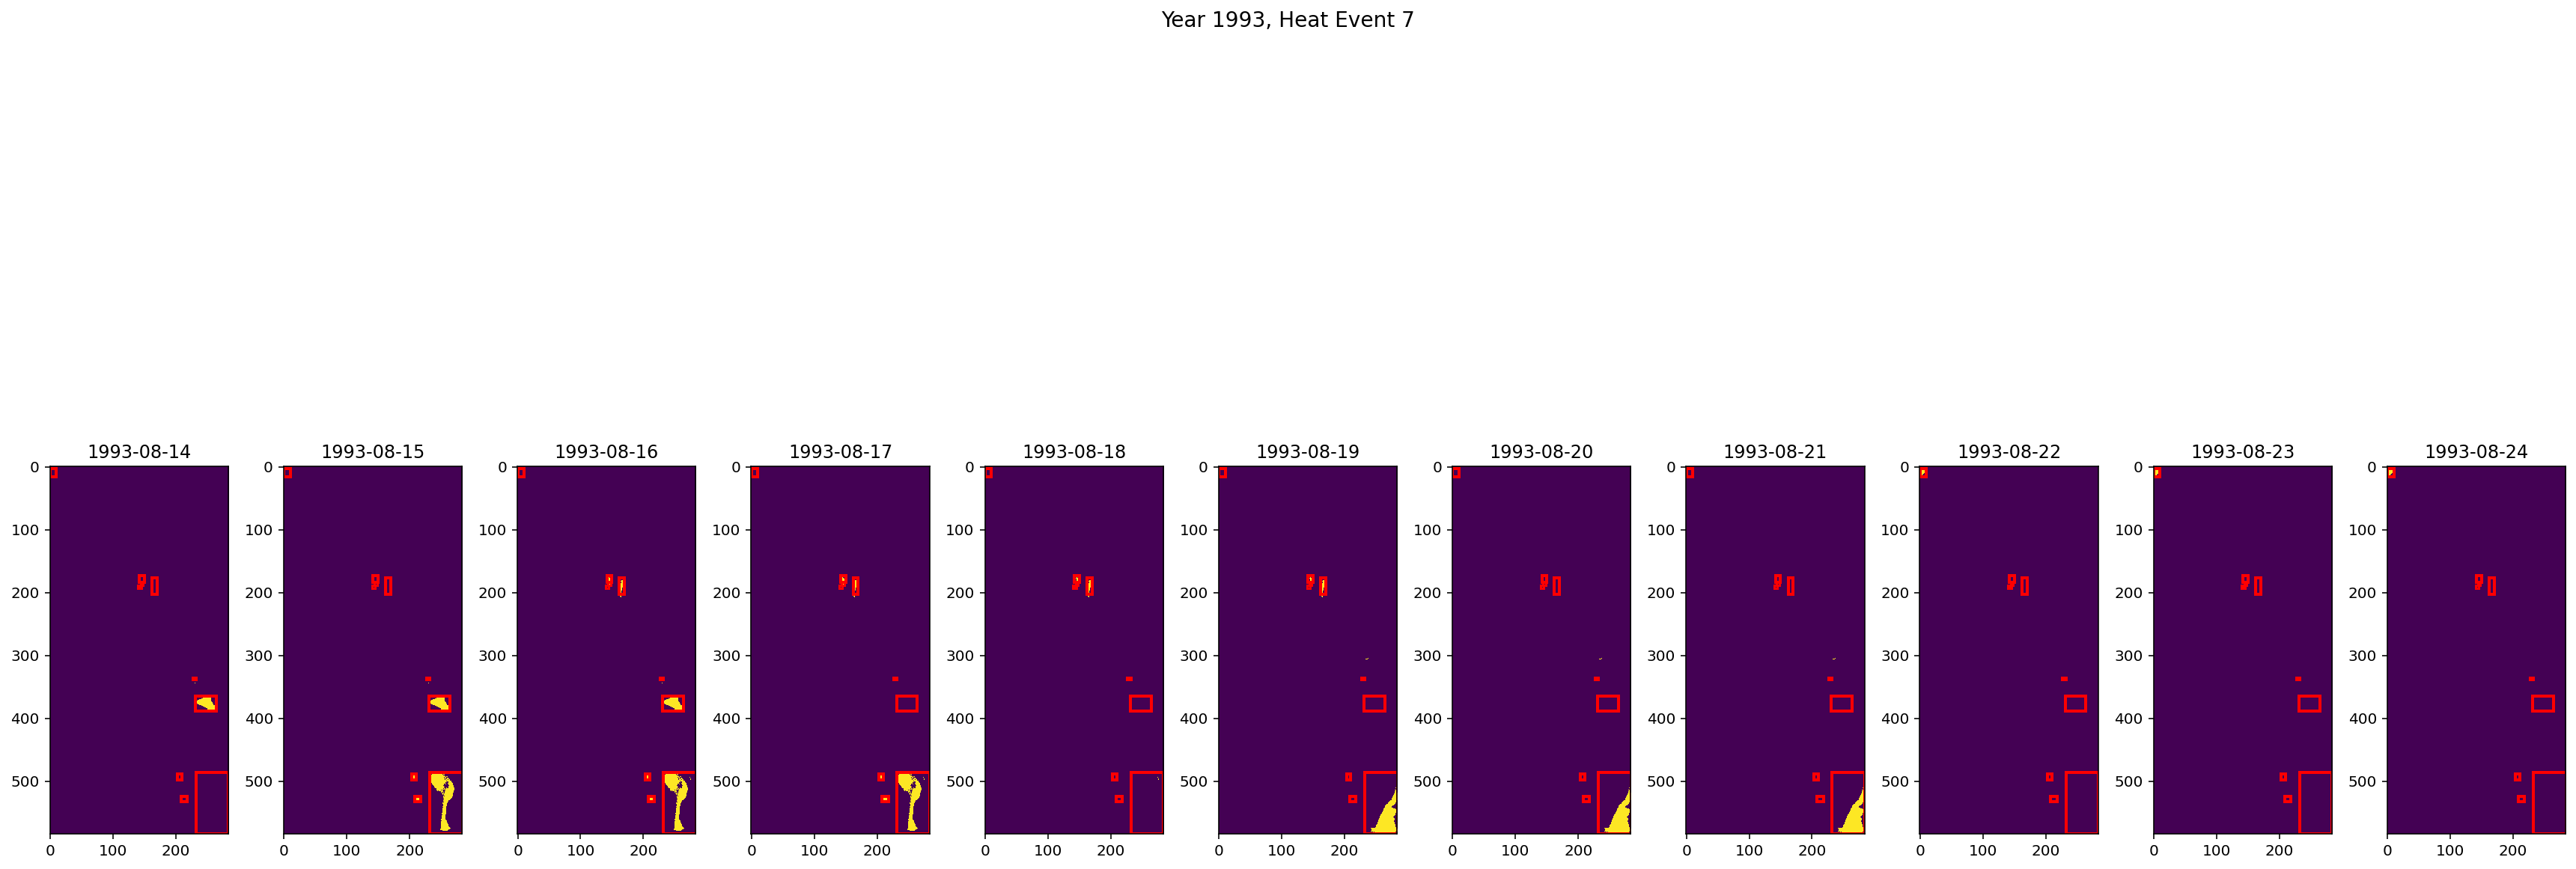

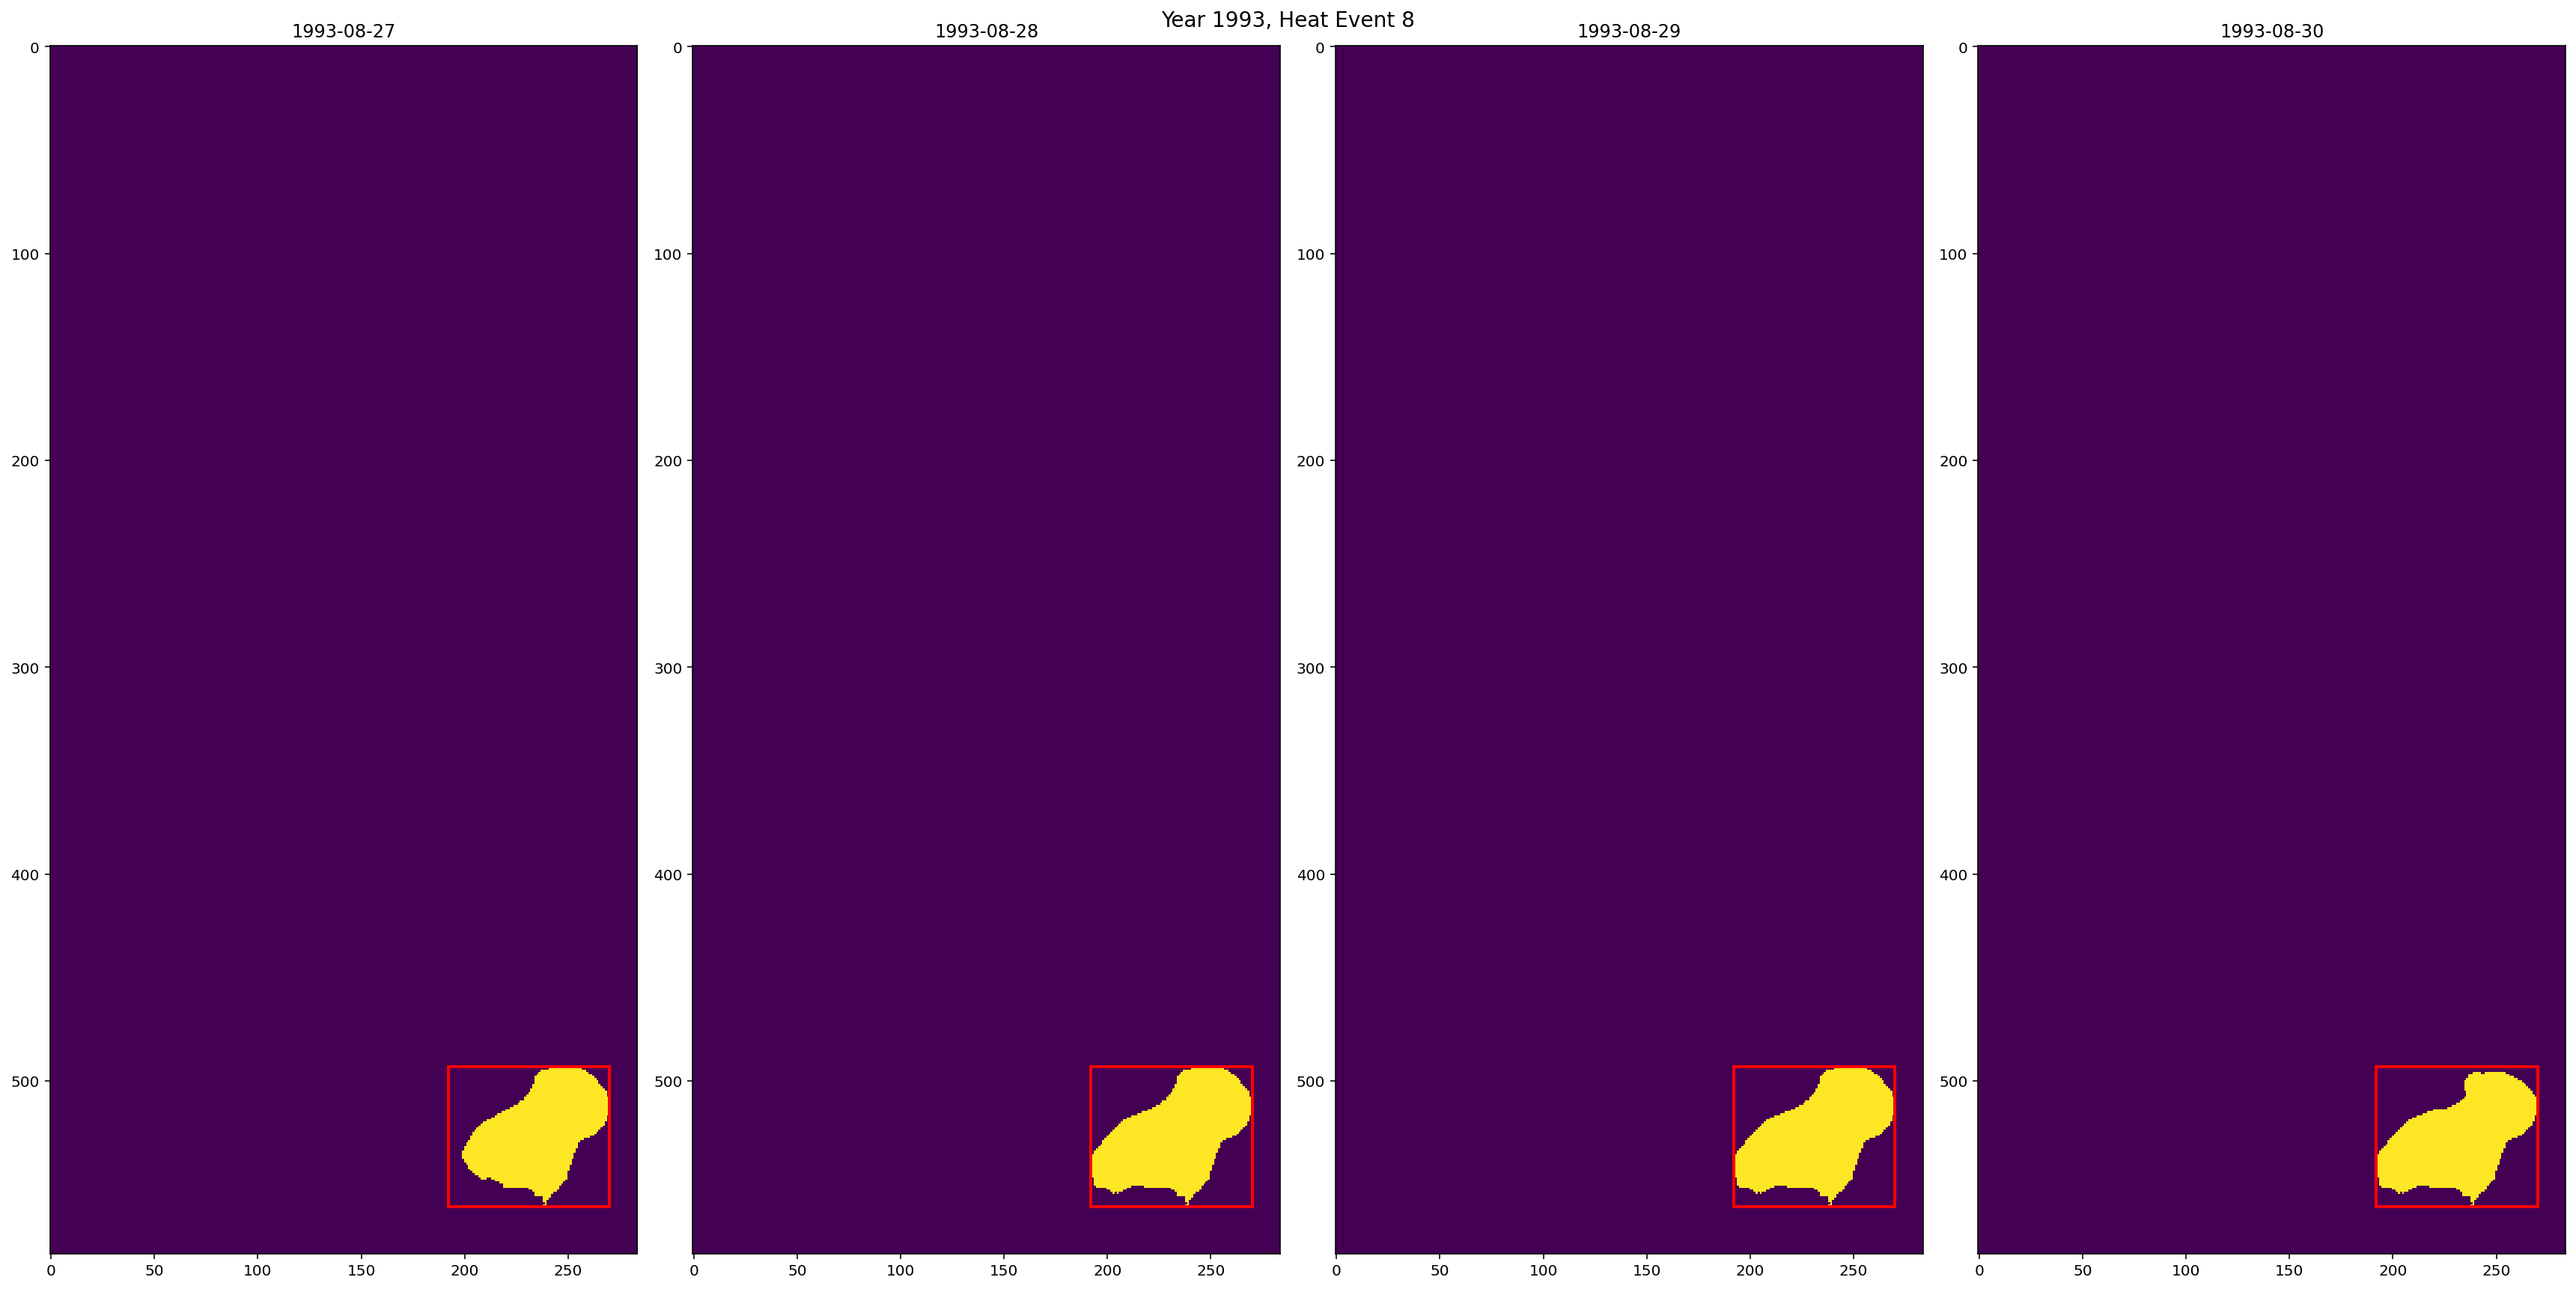

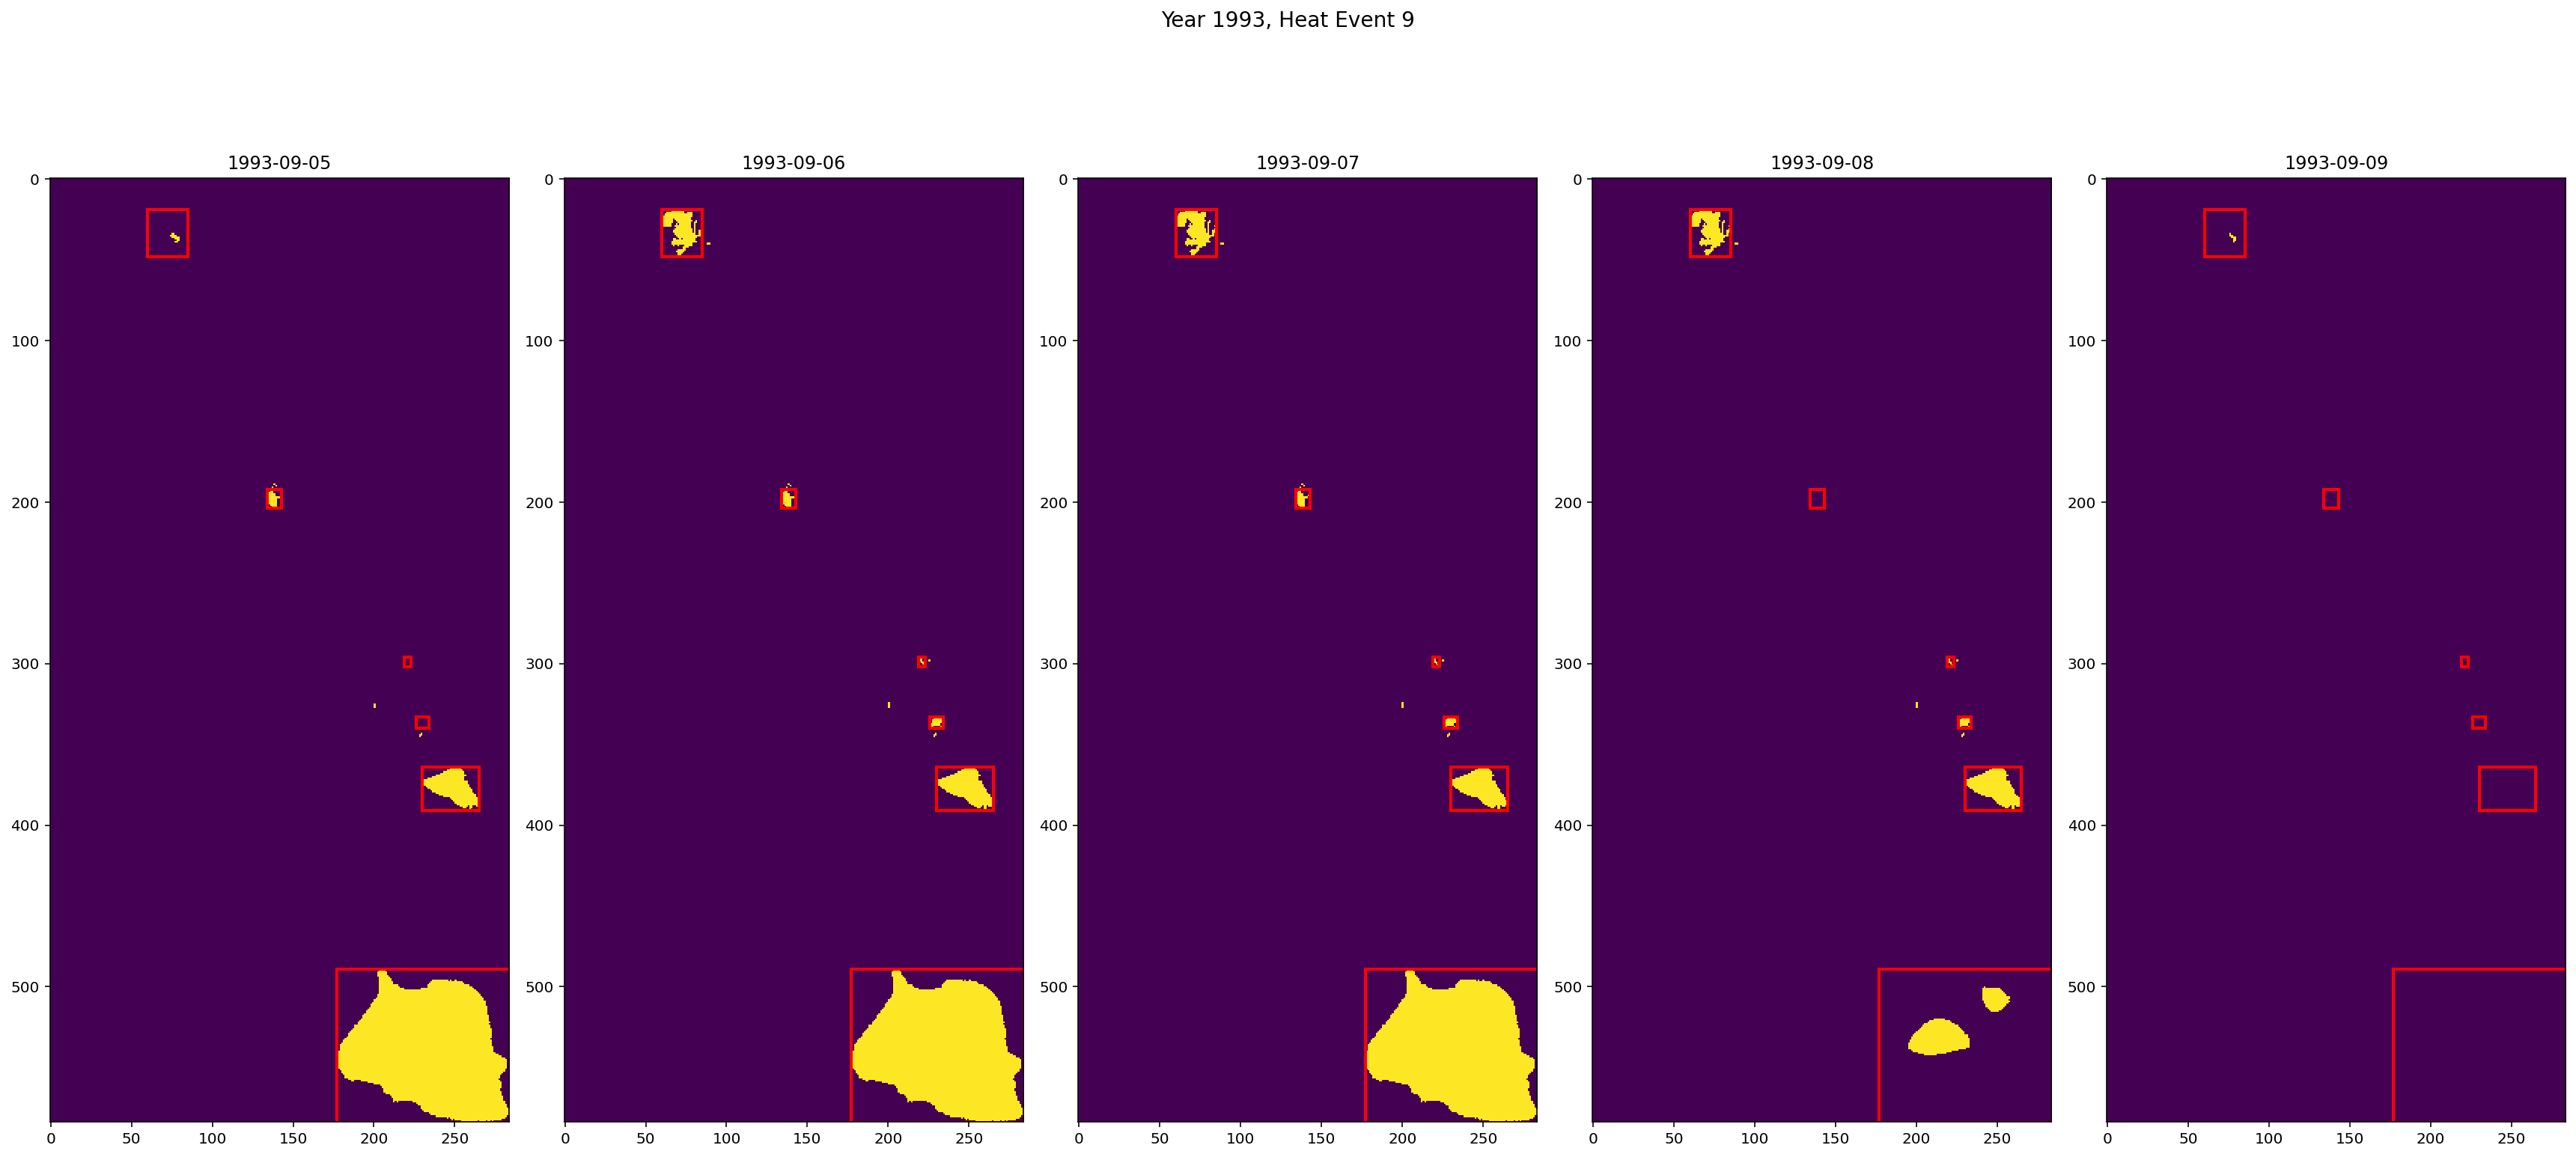

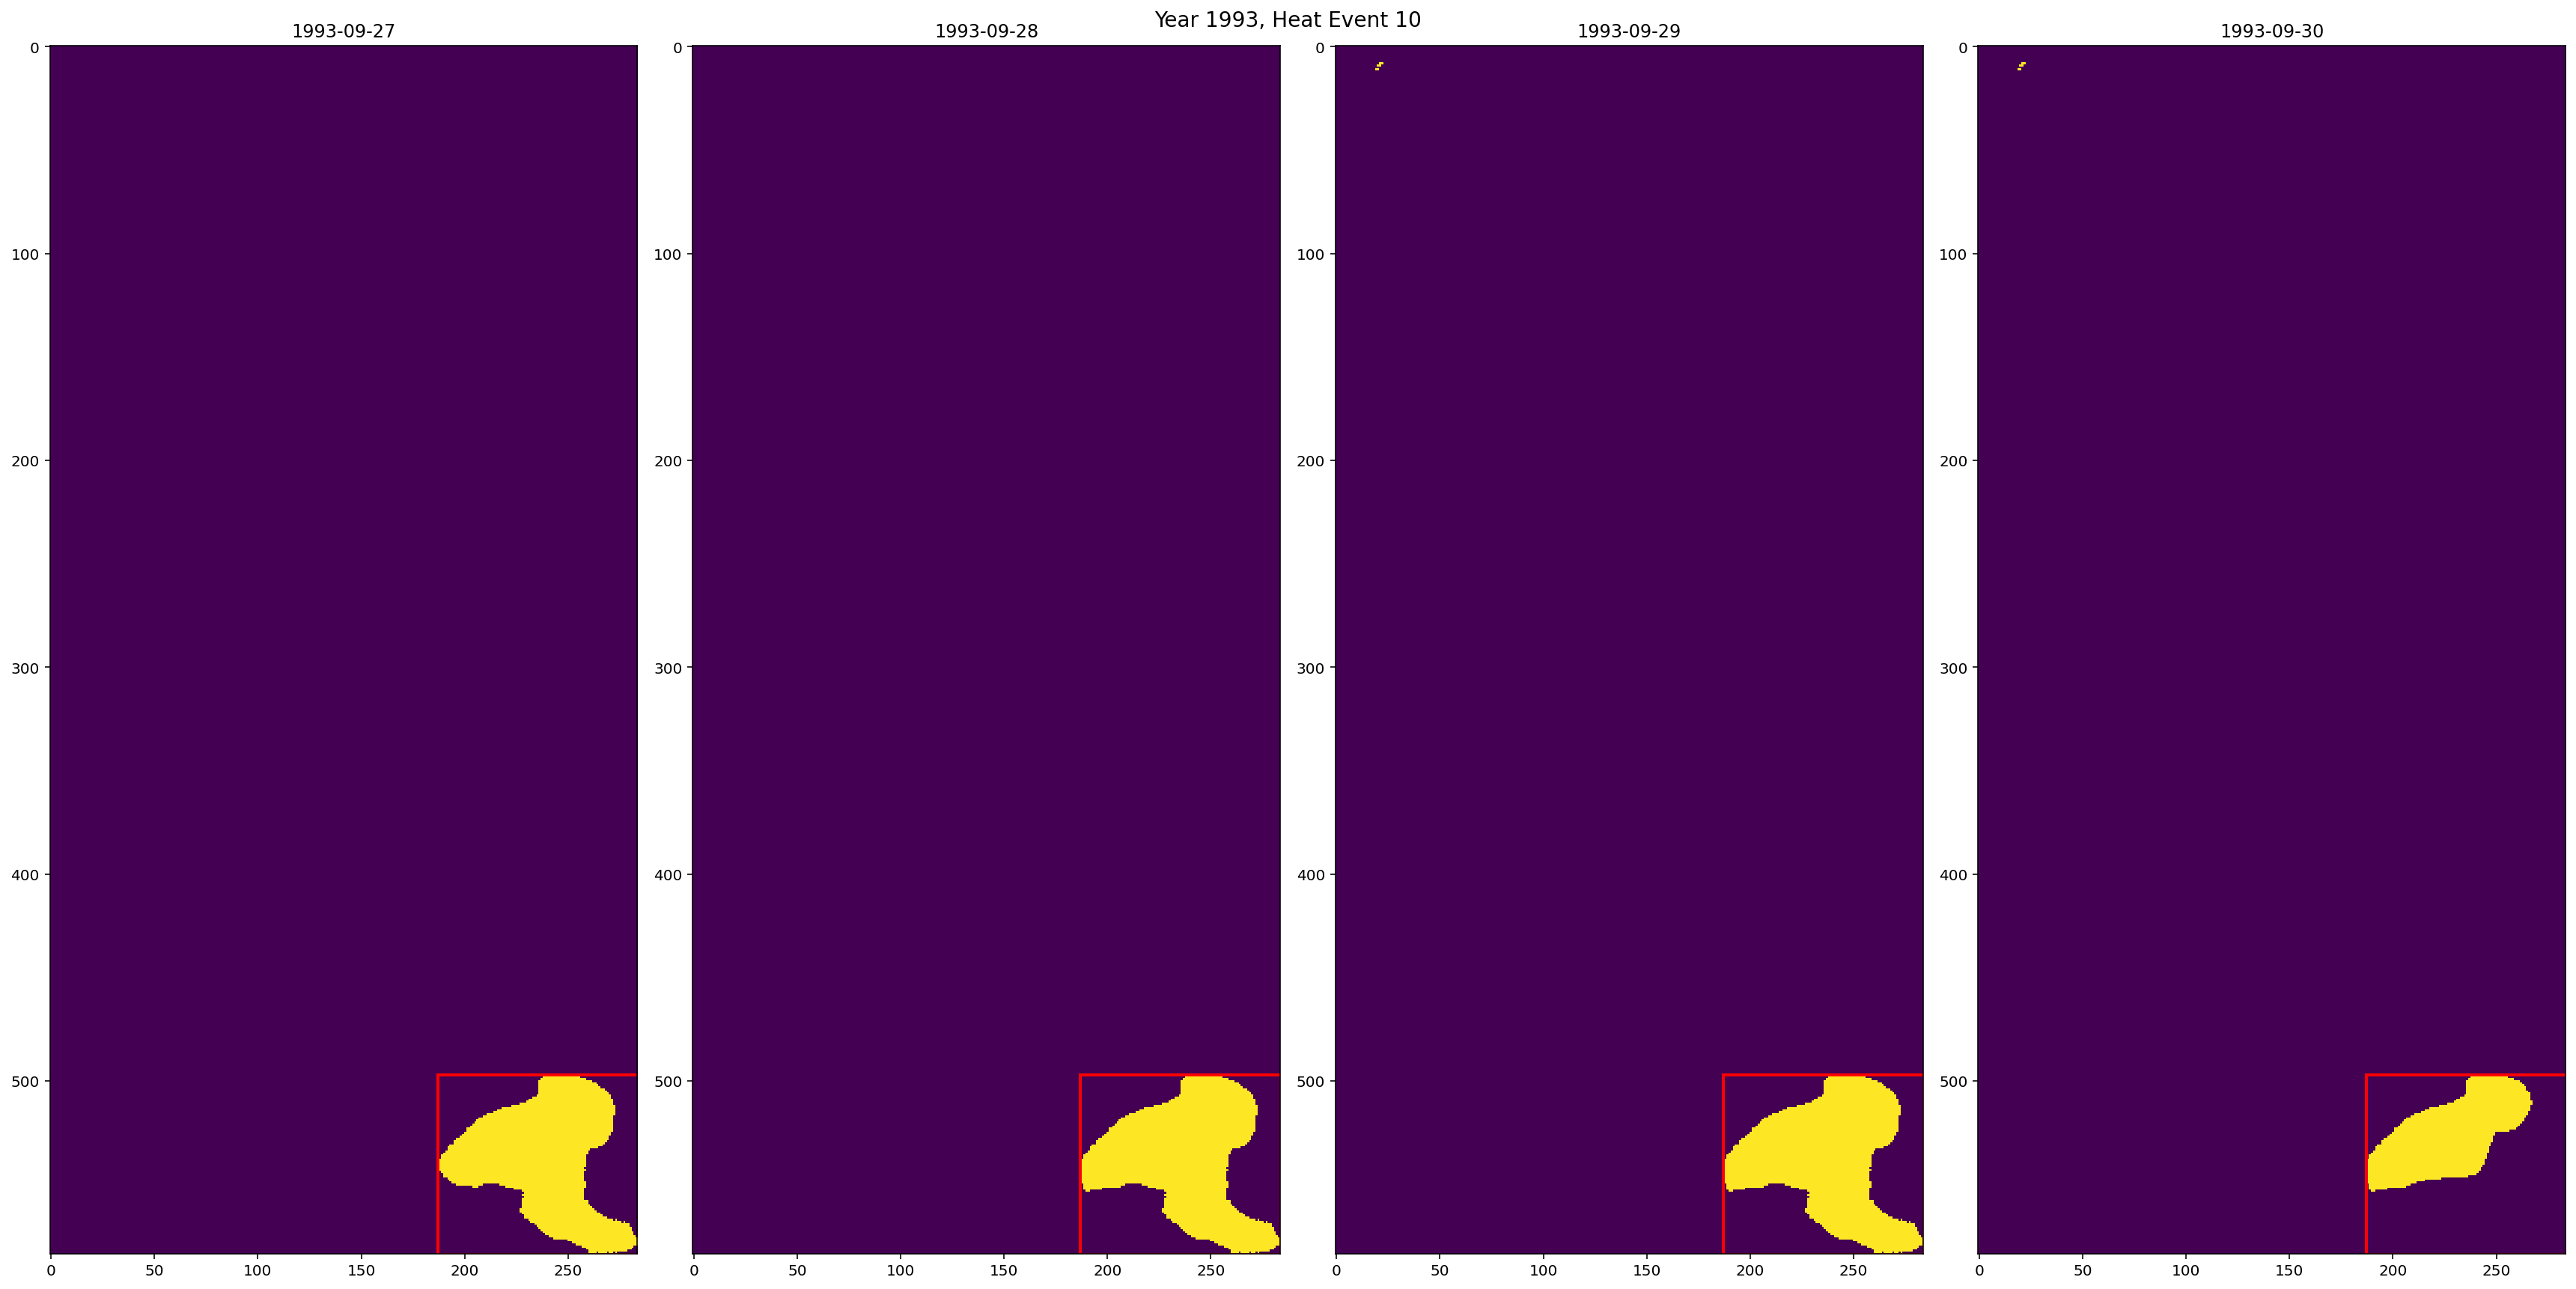

In [95]:
for ev, (i1, i2) in df_events[['i1','i2']].iterrows():

    t_indexes = range(i1,i2+1)

    fig, axs = plt.subplots(1, len(t_indexes), figsize=(24,12))

    for i, idx in enumerate(t_indexes):

        arr2d = arr3d[idx,:,:]

        ax = axs.ravel()[i]
        ax.imshow(arr2d, interpolation='none')
        ax.set_title(dr[idx])

        boxes = df_events['boxes'].iloc[ev]
        for b in boxes:
            x,y,w,h = b
            rect = Rectangle((x, y), w, h, color='red', fill=False, linewidth=2)
            ax.add_patch(rect)
            
    fig.suptitle(f"Year {year}, Heat Event {ev}", fontsize=14)
    fig.tight_layout()